In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(".."))
from core.viz import plot_line, create_subplot_grid, plot_bar, plot_statistical_strip
from core.s3 import S3AssetManager

In [2]:

CORP_PALETTE =  [ "#1c8074","#666666", "#94af92", "#666666", "#f9ee77", "#f5ad68", "#c76931"]


In [3]:
notebook_name = "comayma_microbiologia"
s3 = S3AssetManager(notebook_name=notebook_name)

In [4]:

def scatter_1x2_corporativo(
    df: pd.DataFrame,
    *,
    x_col: str = "log_coliformes",
    y1_col: str = "log_hongos",
    y2_col: str = "log_levaduras",
    color_by: str | None = None,   # p.ej. "Especie"
    width: int = 1000,
    height: int = 500,
    suptitle: str = "Tendencias microbianas (subplot 1×2)",
    output_html: str | None = None,
):
    d = df.copy()

    # Asegurar numéricos
    for c in [x_col, y1_col, y2_col]:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    # Lienzo 1x2
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(
            f"{x_col} vs {y1_col}",
            f"{x_col} vs {y2_col}"
        ),
        horizontal_spacing=0.08
    )

    # --- Subplot 1: x vs y1 (solo valores > 0) ---
    d1 = d[(d[x_col] > 0) & (d[y1_col] > 0)].dropna(subset=[x_col, y1_col])
    if color_by:
        # múltiples trazas por categoría usando colores corporativos
        f1 = px.scatter(
            d1, x=x_col, y=y1_col, color=color_by,
            color_discrete_sequence=CORP_PALETTE, opacity=0.85
        )
        # Muestra leyenda solo en el segundo subplot para no duplicar
        for tr in f1.data:
            tr.showlegend = False
            fig.add_trace(tr, row=1, col=1)
    else:
        fig.add_trace(
            go.Scatter(
                x=d1[x_col], y=d1[y1_col],
                mode="markers",
                marker=dict(size=7, opacity=0.85, color=CORP_PALETTE[0]),
                showlegend=False,
                name=f"{x_col} vs {y1_col}"
            ),
            row=1, col=1
        )

    # --- Subplot 2: x vs y2 (solo valores > 0) ---
    d2 = d[(d[x_col] > 0) & (d[y2_col] > 0)].dropna(subset=[x_col, y2_col])
    if color_by:
        f2 = px.scatter(
            d2, x=x_col, y=y2_col, color=color_by,
            color_discrete_sequence=CORP_PALETTE, opacity=0.85
        )
        # Aquí sí mostramos la leyenda (una sola vez)
        for i, tr in enumerate(f2.data):
            tr.showlegend = True if i == 0 else False
            fig.add_trace(tr, row=1, col=2)
    else:
        fig.add_trace(
            go.Scatter(
                x=d2[x_col], y=d2[y2_col],
                mode="markers",
                marker=dict(size=7, opacity=0.85, color=CORP_PALETTE[2]),
                showlegend=False,
                name=f"{x_col} vs {y2_col}"
            ),
            row=1, col=2
        )

    # Títulos de ejes
    fig.update_xaxes(title_text="log10 Coliformes (UFC/g)", row=1, col=1)
    fig.update_yaxes(title_text="log10 Hongos (UFC/g)",     row=1, col=1)
    fig.update_xaxes(title_text="log10 Coliformes (UFC/g)", row=1, col=2)
    fig.update_yaxes(title_text="log10 Levaduras (UFC/g)",  row=1, col=2)

    # Estilo corporativo + tamaño + fondo transparente + texto negro
    fig.update_layout(
        width=width, height=height,
        title=suptitle, title_x=0.5,
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(color="black"),
        margin=dict(l=70, r=30, t=80, b=60),
        legend=dict(font=dict(color="black"))
    )
    fig.update_xaxes(showline=True, linecolor="black",
                     tickfont=dict(color="black"), title_font=dict(color="black"))
    fig.update_yaxes(showline=True, linecolor="black",
                     tickfont=dict(color="black"), title_font=dict(color="black"))

    if output_html:
        fig.write_html(output_html, include_plotlyjs="cdn", full_html=False)

    return fig



# Colores corporativos
CORP_MARKER = "#1A494C"   # puntos
CORP_BAND   = "rgba(28, 128, 116, 0.08)"  # banda del rango

def scatter_regresion_rango_corporativo(
    df: pd.DataFrame,
    x: str,
    y: str,
    *,
    fit_range_x: tuple[float, float],   # (xmin, xmax) para el AJUSTE
    solo_positivos: bool = True,
    title: str | None = None,
    width: int = 1000,
    height: int = 500,
    output_html: str | None = None,
    reg_line_color: str = "#FF0000",    # ← línea de regresión en ROJO
):
    d = df.copy()
    d[x] = pd.to_numeric(d[x], errors="coerce")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[x, y])

    if solo_positivos:
        d_scatter = d[(d[x] > 0) & (d[y] > 0)].copy()
    else:
        d_scatter = d.copy()

    xmin, xmax = fit_range_x
    d_fit = d_scatter[(d_scatter[x] >= xmin) & (d_scatter[x] <= xmax)].copy()
    if len(d_fit) < 2:
        raise ValueError(f"No hay suficientes puntos en el rango {fit_range_x} para ajustar.")

    xv = d_fit[x].to_numpy()
    yv = d_fit[y].to_numpy()
    slope, intercept = np.polyfit(xv, yv, 1)
    y_pred = intercept + slope * xv
    ss_res = np.sum((yv - y_pred) ** 2)
    ss_tot = np.sum((yv - np.mean(yv)) ** 2)
    r2 = float(1 - ss_res / ss_tot) if ss_tot > 0 else float("nan")
    n = int(len(d_fit))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=d_scatter[x], y=d_scatter[y],
        mode="markers",
        marker=dict(size=7, opacity=0.85, color=CORP_MARKER),
        name="Datos"
    ))

    fig.add_vrect(x0=xmin, x1=xmax, fillcolor=CORP_BAND, line_width=0, layer="below")

    x_line = np.array([xmin, xmax])
    y_line = intercept + slope * x_line
    fig.add_trace(go.Scatter(
        x=x_line, y=y_line,
        mode="lines",
        line=dict(width=3, color=reg_line_color),  # ← rojo
        name="Regresión (rango)"
    ))

    params_txt = (
        f"Ajuste en [{xmin:.2f}, {xmax:.2f}]<br>"
        f"y = {intercept:.3f} + {slope:.3f}·x<br>"
        f"R² = {r2:.3f} · n = {n}"
    )
    fig.add_annotation(
        xref="paper", yref="paper", x=0.02, y=0.98,
        text=params_txt, showarrow=False, align="left",
        font=dict(color="black"), bgcolor="rgba(0,0,0,0)"
    )

    fig.update_layout(
        width=width, height=height,
        title=title or f"{y} vs {x} (regresión en rango)",
        title_x=0.5,
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(color="black"),
        margin=dict(l=70, r=30, t=80, b=60),
        showlegend=False
    )
    fig.update_xaxes(title_text=x, showline=True, linecolor="black",
                     tickfont=dict(color="black"), title_font=dict(color="black"))
    fig.update_yaxes(title_text=y, showline=True, linecolor="black",
                     tickfont=dict(color="black"), title_font=dict(color="black"))

    if output_html:
        fig.write_html(output_html, include_plotlyjs="cdn", full_html=False)

    return fig


def boxplot_corporativo_con_mediana(
    df: pd.DataFrame,
    x: str,
    y: str,
    *,
    color_by: str | None = None,
    title: str | None = None,
    yaxis_title: str | None = None,
    points: str | bool = "outliers",
    solo_y_positivos: bool = False,
    output_html: str | None = None,
    median_line_color: str = "#FF0000",   # rojo
):
    d = df.copy()
    d[y] = pd.to_numeric(d[y], errors="coerce")
    if solo_y_positivos:
        d = d[d[y] > 0]
    d = d.dropna(subset=[x, y])

    kwargs = dict(
        x=x, y=y, points=points,
        title=title or f"Distribución de {y}",
        color_discrete_sequence=CORP_PALETTE,

    )
    if color_by:
        kwargs["color"] = color_by

    fig = px.box(d, **kwargs)
    fig.update_traces(boxmean=False)

    mediana = d[y].median(skipna=True)
    fig.add_hline(
        y=mediana,
        line_dash="dash",
        line_color=median_line_color,
        annotation_text=f"Mediana = {mediana:.2f}",
        annotation_position="top right",
        annotation_font_color="blue"
    )

    # Estilo corporativo + título centrado
    fig.update_layout(
        title_x=0.5,  # << centrado del título
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(color="black"),
        xaxis=dict(showline=True, linecolor="black",
                   tickfont=dict(color="black"), title_font=dict(color="black")),
        yaxis=dict(showline=True, linecolor="black",
                   tickfont=dict(color="black"), title_font=dict(color="black")),
        legend=dict(font=dict(color="black"))
    )
    fig.update_yaxes(title_text=yaxis_title or y)

    if output_html:
        fig.write_html(output_html, include_plotlyjs="cdn", full_html=False)

    return fig


import pandas as pd
import plotly.express as px

# Paleta corporativa por si no existe:
try:
    CORP_PALETTE
except NameError:
    CORP_PALETTE = ["#1C8074", "#666666", "#1A494C", "#94AF92", "#E6ECD8", "#C9C9C9"]

def violin_corporativo_con_mediana(
    df: pd.DataFrame,
    x: str,
    y: str,
    *,
    color_by: str | None = None,      # colorear por columna (opcional)
    title: str | None = None,
    yaxis_title: str | None = None,
    points: str | bool = "outliers",  # "outliers" | "all" | False
    solo_y_positivos: bool = False,
    output_html: str | None = None,
    median_line_color: str = "#FF0000",  # línea GLOBAL de mediana (roja)
    box_inside: bool = True,             # mini box por categoría
    meanline: bool = False,              # línea de MEDIA por categoría
    width: int = 1000,
    height: int = 500,
):
    d = df.copy()
    d[y] = pd.to_numeric(d[y], errors="coerce")
    if solo_y_positivos:
        d = d[d[y] > 0]
    d = d.dropna(subset=[x, y])

    kwargs = dict(
        x=x, y=y,
        points=points,
        box=box_inside,
        title=title or f"Distribución (violín) de {y}",
        color_discrete_sequence=CORP_PALETTE,
    )
    if color_by:
        kwargs["color"] = color_by

    fig = px.violin(d, **kwargs)

    # Activa la línea de MEDIA por categoría (compatible con versiones antiguas)
    if meanline:
        try:
            fig.update_traces(meanline_visible=True, selector=dict(type="violin"))
        except Exception:
            fig.for_each_trace(
                lambda tr: tr.update(meanline=dict(visible=True)) if tr.type == "violin" else None
            )

    # Línea de MEDIANA GLOBAL (todas las categorías)
    mediana = d[y].median(skipna=True)
    fig.add_hline(
        y=mediana,
        line_dash="dash",
        line_color=median_line_color,
        annotation_text=f"Mediana = {mediana:.2f}",
        annotation_position="top right",
        annotation_font_color="black",
    )

    # Estilo corporativo + título centrado + fondo transparente + tamaño
    fig.update_layout(
        width=width, height=height,
        title_x=0.5,
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(color="black"),
        xaxis=dict(showline=True, linecolor="black",
                   tickfont=dict(color="black"), title_font=dict(color="black")),
        yaxis=dict(showline=True, linecolor="black",
                   tickfont=dict(color="black"), title_font=dict(color="black")),
        legend=dict(font=dict(color="black")),
        margin=dict(l=60, r=30, t=70, b=50),
    )
    fig.update_yaxes(title_text=yaxis_title or y)

    if output_html:
        fig.write_html(output_html, include_plotlyjs="cdn", full_html=False)

    return fig


import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

def boxplot_corporativo_con_mediana(
    df: pd.DataFrame,
    x: str,
    y: str,
    *,
    color_by: str | None = None,
    title: str | None = None,
    yaxis_title: str | None = None,
    points: str | bool = "outliers",
    solo_y_positivos: bool = False,
    output_html: str | None = None,
    median_line_color: str = "#FF0000",   # rojo línea global
    median_connect_color: str = "#1f77b4" # color de la(s) línea(s) conectando medianas
):
    d = df.copy()
    d[y] = pd.to_numeric(d[y], errors="coerce")
    if solo_y_positivos:
        d = d[d[y] > 0]
    d = d.dropna(subset=[x, y])

    # Orden consistente del eje X
    # (si x es numérico, ordénalo; si es str/categórico, respeta el orden único de aparición)
    try:
        x_vals_sorted = sorted(pd.to_numeric(d[x], errors="coerce").dropna().unique())
    except Exception:
        x_vals_sorted = d[x].dropna().unique().tolist()

    kwargs = dict(
        x=x, y=y, points=points,
        title=title or f"Distribución de {y}",
        color_discrete_sequence=CORP_PALETTE,
    )
    if color_by:
        kwargs["color"] = color_by

    fig = px.box(d, **kwargs)
    fig.update_traces(boxmean=False)

    # Línea horizontal en la mediana global
    #mediana_global = d[y].median(skipna=True)
    #fig.add_hline(
    #    y=mediana_global,
    #    line_dash="dash",
    #    line_color=median_line_color,
    #    annotation_text=f"Mediana = {mediana_global:.2f}",
    #    annotation_position="top right",
    #    annotation_font_color="blue"
    #)

    # ===== Conectar medianas por grupo en X (y por color si aplica) =====
    if color_by:
        # Una línea por cada categoría en color_by
        meds = (
            d.groupby([x, color_by], dropna=False)[y]
              .median()
              .reset_index()
        )

        # Asegurar orden por X (numérico si aplica)
        def order_key(val):
            try:
                return float(val)
            except Exception:
                # fallback: orden por string
                return str(val)

        for k, sub in meds.groupby(color_by, dropna=False):
            sub = sub.sort_values(by=x, key=lambda s: s.map(order_key))
            fig.add_trace(
                go.Scatter(
                    x=sub[x],
                    y=sub[y],
                    mode="lines+markers",
                    name=f"Mediana ({color_by}={k})",
                    line=dict(dash="dash"),
                    marker=dict(size=6),
                    legendgroup=f"med-{k}",
                    showlegend=True
                )
            )
    else:
        # Una sola línea conectando las medianas por X
        meds = d.groupby(x, dropna=False)[y].median().reset_index()

        # Ordenar por X como arriba
        def order_key(val):
            try:
                return float(val)
            except Exception:
                return str(val)

        meds = meds.sort_values(by=x, key=lambda s: s.map(order_key))

        fig.add_trace(
            go.Scatter(
                x=meds[x],
                y=meds[y],
                mode="lines+markers",
                name=f"Mediana por grupo ({x})",
                line=dict(dash="dash"),
                marker=dict(size=6),
                showlegend=True
            )
        )

    # Estilo corporativo + título centrado
    fig.update_layout(
        title_x=0.5,
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(color="black"),
        xaxis=dict(
            showline=True, linecolor="black",
            tickfont=dict(color="black"), title_font=dict(color="black"),
            categoryorder="array", categoryarray=x_vals_sorted
        ),
        yaxis=dict(showline=True, linecolor="black",
                   tickfont=dict(color="black"), title_font=dict(color="black")),
        legend=dict(font=dict(color="black"))
    )
    fig.update_yaxes(title_text=yaxis_title or y)

    if output_html:
        fig.write_html(output_html, include_plotlyjs="cdn", full_html=False)

    return fig



import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

# Paleta corporativa
CORP_PALETTE = ["#1C8074", "#666666",  "#E6ECD8", "#C9C9C9", "#1A494C", "#94AF92", "#E6ECD8", "#C9C9C9"]


def boxgrid_2x2_corporativo(
    df: pd.DataFrame,
    *,
    x_col: str,
    y_cols: list[str],                 # 4 variables: [coliformes, rat, levaduras, hongos]
    subplot_titles: list[str] | None = None,
    points: str | bool = "outliers",
    suptitle: str = "Distribuciones",
    output_html: str | None = None,
    solo_y_positivos: bool = False,
    width: int = 1000,
    height: int = 500,
    median_line_color: str = "#FF0000",
):
    """
    Grid 2x2 de boxplots corporativos con línea de mediana en rojo.
    Guarda HTML si se indica.
    """
    assert len(y_cols) == 4, "y_cols debe tener 4 variables (2x2)."
    d = df.copy()
    for y in y_cols:
        d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[x_col] + y_cols)
    if solo_y_positivos:
        for y in y_cols:
            d = d[d[y] > 0]

    titles = subplot_titles or y_cols
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=titles,
        horizontal_spacing=0.08,
        vertical_spacing=0.3
    )

    def rc(idx):  # índice -> (fila, columna)
        return (1 + idx // 2, 1 + idx % 2)

    # Añadir cada boxplot
    for i, y in enumerate(y_cols):
        fb = px.box(
            d, x=x_col, y=y,
            points=points,
            color_discrete_sequence=CORP_PALETTE,
        )
        # Evita leyendas repetidas por traza
        for tr in fb.data:
            tr.showlegend = False
            fig.add_trace(tr, row=rc(i)[0], col=rc(i)[1])

        # Mediana global de cada variable (línea roja)
        med = d[y].median(skipna=True)
        fig.add_hline(
            y=med,
            line_dash="dash",
            line_color=median_line_color,
            annotation_text=f"Mediana = {med:.2f}",
            annotation_position="top right",
            annotation_font_color="black",
            row=rc(i)[0], col=rc(i)[1]
        )

        # Títulos de ejes
        fig.update_xaxes(title_text=x_col, row=rc(i)[0], col=rc(i)[1])
        fig.update_yaxes(title_text="log10(UFC/g)", row=rc(i)[0], col=rc(i)[1])

    # Estilo global + tamaño
    fig.update_layout(
        width=width,
        height=height,
        title=suptitle,
        title_x=0.5,  # centrado
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(color="black"),
        legend=dict(font=dict(color="black")),
        margin=dict(l=70, r=30, t=90, b=60),
    )
    fig.update_xaxes(showline=True, linecolor="black",
                     tickfont=dict(color="black"), title_font=dict(color="black"))
    fig.update_yaxes(showline=True, linecolor="black",
                     tickfont=dict(color="black"), title_font=dict(color="black"))

    if output_html:
        fig.write_html(output_html, include_plotlyjs="cdn", full_html=True)

    return fig


# =========================
# EJEMPLOS DE USO
# =========================
# Ejemplo 1: un solo boxplot
# boxplot_corporativo_con_mediana(
#     r, x="AW", y="log_coliformes",
#     title="log10 Coliformes por rango de actividad de agua",
#     yaxis_title="log10(UFC/g)",
#     points="outliers",
#     output_html=f"{ROOT_IMAGEN}/box_coliformes.html",
#     width=1000, height=500
# )

# Ejemplo 2: grid 2×2
# fig = boxgrid_2x2_corporativo(
#     r,
#     x_col="AW",
#     y_cols=["log_coliformes", "log_rat", "log_levaduras", "log_hongos"],
#     subplot_titles=[
#         "log10 Coliformes por rango de actividad de agua",
#         "log10 RAT por rango de actividad de agua",
#         "log10 Levaduras por rango de actividad de agua",
#         "log10 Hongos por rango de actividad de agua",
#     ],
#     suptitle="Boxplots por AW (paleta corporativa, mediana roja)",
#     output_html=f"{ROOT_IMAGEN}/boxgrid_aw_2x2.html",
#     width=1000, height=500
# )
# fig.show()


def scatter_corporativo(
    df: pd.DataFrame,
    *,
    x_col: str,
    y_col: str,
    color_by: str | None = None,     # p.ej. "Especie"
    filter_col: str | None = None,   # p.ej. "log_coliformes" (col de filtro)
    min_filter_val: float | None = None,  # p.ej. 0  (umbral para filter_col)
    width: int = 900,
    height: int = 520,
    title: str = "",
    output_html: str | None = None,
    palette: list[str] | None = None
):
    d = df.copy()

    # Asegurar numéricos en ejes
    d[x_col] = pd.to_numeric(d[x_col], errors="coerce")
    d[y_col] = pd.to_numeric(d[y_col], errors="coerce")

    # Filtro opcional por tercera columna (como r[r['log_coliformes']>0])
    if filter_col is not None:
        d[filter_col] = pd.to_numeric(d[filter_col], errors="coerce")
        if min_filter_val is not None:
            d = d[d[filter_col] > min_filter_val]
        d = d.dropna(subset=[filter_col])

    d = d.dropna(subset=[x_col, y_col])

    # Paleta corporativa (usa CORP_PALETTE si existe; si no, una de Plotly)
    if palette is None:
        palette = globals().get("CORP_PALETTE", px.colors.qualitative.Set2)

    fig = go.Figure()

    if color_by and color_by in d.columns:
        cats = d[color_by].astype(str).fillna("NA").unique().tolist()
        for i, c in enumerate(cats):
            g = d[d[color_by].astype(str) == c]
            fig.add_trace(
                go.Scatter(
                    x=g[x_col], y=g[y_col],
                    mode="markers",
                    name=str(c),
                    marker=dict(size=7, opacity=1,
                                color=palette[i % len(palette)]),
                )
            )
        showlegend = True
    else:
        fig.add_trace(
            go.Scatter(
                x=d[x_col], y=d[y_col],
                mode="markers",
                name=f"{x_col} vs {y_col}",
                marker=dict(size=7, opacity=1,
                            color=palette[0]),
            )
        )
        showlegend = False

    # Estilo corporativo
    fig.update_layout(
        width=width, height=height,
        title=title, title_x=0.5,
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(color="black"),
        margin=dict(l=70, r=30, t=60, b=60),
        legend=dict(font=dict(color="black"), orientation="h",
                    yanchor="bottom", y=1.02, xanchor="left", x=0),
        showlegend=showlegend
    )
    fig.update_xaxes(title_text=x_col, showline=True, linecolor="black",
                     tickfont=dict(color="black"), title_font=dict(color="black"))
    fig.update_yaxes(title_text=y_col, showline=True, linecolor="black",
                     tickfont=dict(color="black"), title_font=dict(color="black"))

    if output_html:
        fig.write_html(output_html, include_plotlyjs="cdn", full_html=False)

    return fig


In [6]:
df_pel = s3.read_excel("raw/comayma/Granulometria acumulada.xlsx", sheet_name="Pellet.", skiprows=9)
df_pel.columns = [x.strip() for x in df_pel.columns]

df_pel = df_pel[df_pel["OP"].notnull()]
df_pel['OP'] = df_pel['OP'].astype(int)
df_pel["FECHA DE ANALISIS"] = pd.to_datetime(df_pel["FECHA DE ANALISIS"])
cols = [
    'HUMEDAD',
    'AW 0.70 MAX',
    'PDI',
    'TAMIZ # 5 MIN. 90%', 'TAMIZ # 12 MAX. 5%',
    'BANDEJA MAX. 5%',
    '70 Aves, 80 Cerdo, 90 Ganado', 'PDI',
    'T_PARTICULA', 'Densidad\n (g/l)',
    'longitud  mm',
    'VOLUMEN mm^3', 'Analista', '% HUMEDAD TEORICO', 'RADIO PELLET',
    'Log Dew',
]
for col in cols:
    df_pel[col] = pd.to_numeric(df_pel[col], errors='coerce')





/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [10]:
df_mico24 = s3.read_excel("raw/comayma/Micotoxinas y Microbiología 2024.xlsx", sheet_name="Microbiologia", skiprows=7)
df_mico25 = s3.read_excel("raw/comayma/Micotoxinas y Microbiología 2025.xlsx", sheet_name="Microbiologia", skiprows=7)
df_mico = pd.concat([df_mico24, df_mico25])
df_mico = df_mico[df_mico["OP"].astype(str).str.isdigit()]
df_mico.columns = [x.strip() for x in df_mico.columns]


cols_micro_num = [
     'E.COLI\n< 10 Ufc/g', 'COLIFORMES\n100,000 Ufc/g',
       'RAT\n1,000,000 Ufc/g', 'LEVADURAS\n15,000 Ufc/g',
       'HONGOS\n15,000 Ufc/g', 'SALMONELLA\nAusencia', 'Brill',
]

for col in cols_micro_num:
    df_mico[col] = pd.to_numeric(df_mico[col], errors='coerce').fillna(0)
rename = {
    'E.COLI\n< 10 Ufc/g': 'Ecoli',
    'COLIFORMES\n100,000 Ufc/g': 'Coliformes_100000',
    'RAT\n1,000,000 Ufc/g': 'Rat_1000000',
    'LEVADURAS\n15,000 Ufc/g': 'Levaduras_15000',
    'HONGOS\n15,000 Ufc/g': 'Hongos_15000',
    'SALMONELLA\nAusencia': 'Salmonella',
}
df_mico = df_mico.rename(columns=rename)

cols_micro = [
 'OP', 'Ecoli',
       'Coliformes_100000', 'Rat_1000000', 'Levaduras_15000', 'Hongos_15000',
       'Salmonella', 'Brill', 'Formula', 'Cliente', 'Producto',
       'Fecha Producción', 'Especie', 'Categoria',
]
df_mico = df_mico[cols_micro]

In [11]:
path_base = "raw/comayma/"
init_harinas = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='Inicio Harinas', skiprows=8)
init_harinas["sheet"] ='Inicio Harinas'

df_ganado = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name="Ganado H", skiprows=6)
df_ganado["sheet"] = "Ganado H"

basemayma = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name="Basemayma", skiprows=7)
basemayma["sheet"] ='Basemayma'

fin_broiler = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name="FIN BROILER HARINA", skiprows=4)
fin_broiler["sheet"] ='FIN BROILER HARINA'

postura = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name="Postura H.", skiprows=4)
postura["sheet"] ='Postura H'

crecimiento = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name=' Crecimiento Harina', skiprows=8)
crecimiento["sheet"] ='Crecimiento H'

cons = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='Consolidado', skiprows=0)
cons["sheet"] ='Consolidado'
des = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='Desarrollo Harina', skiprows=3)
des["sheet"] ='Desarrollo H'

cerdos_harinas = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='Cerdos Harinas', skiprows=3)
cerdos_harinas["sheet"] ='Cerdos Harinas'

preinicio = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='Preinicio Gr.', skiprows=8)
preinicio["sheet"] ='Preinicio Gr'

inicio = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='Inicio Gr.', skiprows=6)
inicio["sheet"] ='Inicio Gr'

micropellet_2 = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='MICROPELLET 2.00mm', skiprows=9)
micropellet_2["sheet"] ='MICROPELLET 2'

micropellet_25 = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='MICROPELLET 2.5mm  (2)', skiprows=9)
micropellet_25["sheet"] ='MICROPELLET 2.5mm  (2)'

inicio_micropellet = s3.read_excel(f"{path_base}Granulometria acumulada.xlsx", sheet_name='INICIO MICROPELLET', skiprows=9)
inicio_micropellet["sheet"] ='INICIO MICROPELLET'

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be remov

In [12]:
cols_ref = ['OP', 'FECHA DE PRODUCCIÓN', 'CÓDIGO', 'DESCRIPCION', 'HUMEDAD', 'AW 0.70 MAX',"sheet"]
rename = {'DESCRIPCIÓN': 'DESCRIPCION', 'HUMEDAD 13%': 'HUMEDAD', 'DESCRIPCION': 'DESCRIPCION',}#'Humedad MAX. 13%': 'HUMEDAD','Humedad 12.5% MAX':  'HUMEDAD'

df_ganado = df_ganado.rename(columns=rename)
df_ganado = df_ganado.rename(columns={"Tamaño de Partícula": "Tamaño Particulas"})
df_ganado = df_ganado[df_ganado['OP'].notnull()][cols_ref+["Tamaño Particulas"]].copy()
df_ganado.drop_duplicates('OP', inplace=True)

init_harinas = init_harinas.rename(columns=rename)
init_harinas = init_harinas.rename(columns={"TAMAÑO PARTICULA": "Tamaño Particulas"})

init_harinas = init_harinas[init_harinas['OP'].notnull()][cols_ref+["Tamaño Particulas"]].copy()
init_harinas.drop_duplicates('OP', inplace=True)

basemayma = basemayma.rename(columns=rename)
basemayma = basemayma.rename(columns={"T_PARTICULA": "Tamaño Particulas"})

basemayma = basemayma[basemayma['OP'].notnull()][cols_ref+["Tamaño Particulas"]].copy()
basemayma.drop_duplicates('OP', inplace=True)

fin_broiler = fin_broiler.rename(columns={'Humedad MAX. 13%': 'HUMEDAD', 'DESCRIPCIÓN': 'DESCRIPCION'})
fin_broiler = fin_broiler.rename(columns={"T_PARTICULA": 'Tamaño Particulas'})
fin_broiler = fin_broiler[fin_broiler['OP'].notnull()][cols_ref+["Tamaño Particulas"]].copy()
fin_broiler.drop_duplicates('OP', inplace=True)

postura = postura.rename(columns={'Humedad MAX. 13%': 'HUMEDAD', 'DESCRIPCIÓN': 'DESCRIPCION'})
postura = postura.rename(columns={"T_PARTICULA (1200 +/- 100)": 'Tamaño Particulas'})
postura = postura[postura['OP'].notnull()][cols_ref+["Tamaño Particulas"]].copy()
postura.drop_duplicates('OP', inplace=True)

crecimiento = crecimiento.rename(columns=rename)
crecimiento = crecimiento.rename(columns={'TAMAÑO PARTICULA': "Tamaño Particulas"})

crecimiento = crecimiento[crecimiento['OP'].notnull()][cols_ref+['Tamaño Particulas']].copy()
crecimiento.drop_duplicates('OP', inplace=True)

des = des.rename(columns=rename)
des = des[des['OP'].notnull()][cols_ref].copy()
des.drop_duplicates('OP', inplace=True)

cerdos_harinas = cerdos_harinas.rename(columns={'Humedad MAX. 13%': 'HUMEDAD','DESCRIPCIÓN': 'DESCRIPCION'})
cerdos_harinas = cerdos_harinas.rename(columns={'T_PARTICULA': 'Tamaño Particulas'})

cerdos_harinas = cerdos_harinas[cerdos_harinas['OP'].notnull()][cols_ref+['Tamaño Particulas']].copy()
cerdos_harinas.drop_duplicates('OP', inplace=True)

preinicio = preinicio.rename(columns=rename)
preinicio = preinicio[preinicio['OP'].notnull()][cols_ref].copy()
preinicio.drop_duplicates('OP', inplace=True)

inicio = inicio.rename(columns=rename)
inicio = inicio.rename(columns={"T_PARTICULA (1800 µm)": "Tamaño Particulas"})
inicio = inicio[inicio['OP'].notnull()][cols_ref+["Tamaño Particulas"]].copy()
inicio.drop_duplicates('OP', inplace=True)

micropellet_2 = micropellet_2.rename(columns={'HUMEDAD 13% MAX': 'HUMEDAD','DESCRIPCIÓN': 'DESCRIPCION'})
micropellet_2 = micropellet_2.rename(columns={'T_PARTICULA': 'Tamaño Particulas'})
micropellet_2 = micropellet_2[micropellet_2['OP'].notnull()][cols_ref+['Tamaño Particulas']].copy()
micropellet_2.drop_duplicates('OP', inplace=True)

micropellet_25 = micropellet_25.rename(columns={'HUMEDAD 13% MAX': 'HUMEDAD','DESCRIPCIÓN': 'DESCRIPCION'})
micropellet_25 = micropellet_25[micropellet_25['OP'].notnull()][cols_ref].copy()
micropellet_25.drop_duplicates('OP', inplace=True)

inicio_micropellet = inicio_micropellet.rename(columns={'HUMEDAD 13% MAX': 'HUMEDAD', 'DESCRIPCIÓN': 'DESCRIPCION'})
inicio_micropellet = inicio_micropellet[inicio_micropellet['OP'].notnull()][cols_ref].copy()
inicio_micropellet.drop_duplicates('OP', inplace=True)

df_concat = pd.concat([df_ganado, init_harinas, basemayma, fin_broiler, postura,
                       crecimiento, des, cerdos_harinas, preinicio, inicio, micropellet_2, micropellet_25])
df_concat = df_concat.rename(columns={'AW 0.70 MAX':  'aW',
                                      })

In [13]:
df_concat["FECHA DE PRODUCCIÓN"] = pd.to_datetime(df_concat["FECHA DE PRODUCCIÓN"], errors='coerce')
df_concat["OP"] = pd.to_numeric(df_concat["OP"], downcast='integer', errors='coerce')
df_concat = df_concat[df_concat["OP"].notnull()]
df_concat["OP"] = df_concat["OP"].astype(int)
df_concat["FECHA DE PRODUCCIÓN"].isnull().sum(), df_concat["OP"].isnull().sum()

(315, 0)

In [14]:
df_concat[df_concat.duplicated(["OP"],keep=False,)].sort_values('OP')

,OP,FECHA DE PRODUCCIÓN,CÓDIGO,DESCRIPCION,HUMEDAD,aW,sheet,Tamaño Particulas
155,1044257,2024-04-03,237.0,NUTRIMAYMA INICIO BROILER HA,11.72,0.62,Crecimiento H,778.255706
79,1044257,2024-04-03,237.0,NUTRIMAYMA INICIO BROILER HA,11.72,0.62,Inicio Harinas,778.255706
150,1044315,2024-04-01,246.0,INICIO BROILER,12.13,0.62,Crecimiento H,703.265371
74,1044315,2024-04-01,246.0,INICIO BROILER,12.13,0.62,Inicio Harinas,703.265371
151,1044416,2024-04-02,45.0,CRECIMIENTO POLLA REPROD. ROSS 308,11.86,0.64,Crecimiento H,849.112433
...,...,...,...,...,...,...,...,...
917,1064397,2025-05-03,920.0,PONED. BAJO CONSUMO CYM ASO,12.58,0.68,Crecimiento H,1032.791463
13770,1064695,2025-04-30,910.0,CRECIMIENTO POLLA CYM ASO,NaN,0.68,Postura H,1338.858519
913,1064695,2025-04-30,910.0,CRECIMIENTO POLLA CYM ASO,12.63,0.69,Crecimiento H,1272.976456
1281,1065533,2025-05-16,265.0,INICIO BROILER GRANULADO,12.2,0.7,Inicio Gr,1827.119014


In [15]:
df_concat = df_concat.drop_duplicates(subset=['OP'])
df_concat

,OP,FECHA DE PRODUCCIÓN,CÓDIGO,DESCRIPCION,HUMEDAD,aW,sheet,Tamaño Particulas
0,1040135,2024-01-03,522.0,FORRAMAYMA GANADO HARINA,11.99,0.65,Ganado H,632.170198
1,1039835,2024-01-03,514.0,LACTOMAYMA HARINA 18,11.71,0.66,Ganado H,624.626233
2,1039975,2024-01-03,516.0,LACTOMAYMA HARINA 22,11.69,0.65,Ganado H,632.212876
3,1040343,2024-01-05,522.0,FERRAMAYMA GANADO,11.65,0.67,Ganado H,663.264802
4,1040836,2024-01-05,514.0,LACTOMAYMA 18,12.24,0.63,Ganado H,675.362539
...,...,...,...,...,...,...,...,...
196,1066251,2025-05-30,340.0,LECHOMAYMA L1 MICROPELLET CLIENTES,10.75,0.62,MICROPELLET 2.5mm (2),NaN
197,1066253,2025-05-30,341.0,LECHOMAYMA L2 MICROPELLET CLIENTES,11.47,0.68,MICROPELLET 2.5mm (2),NaN
198,1066254,2025-05-31,342.0,LECHOMAYMA L3 MICROPELLET CLIENTES,12.55,0.7,MICROPELLET 2.5mm (2),NaN
199,1066318,2025-05-31,430.0,CERDO PRE INICIO F3 43-51 DIAS ROPE,12.71,0.69,MICROPELLET 2.5mm (2),NaN


## OPs con reclamos

In [16]:

ops_reclamos = [1069884, 1060011, 1060012, 1061078, 1060891,1061078, 1060811, 1060390, 1060572]

df_concat[df_concat["OP"].isin(ops_reclamos)]

,OP,FECHA DE PRODUCCIÓN,CÓDIGO,DESCRIPCION,HUMEDAD,aW,sheet,Tamaño Particulas
749,1060390,2025-02-06,238.0,NUTRIMAYMA FIN BROILER HA,NaN,0.66,FIN BROILER HARINA,1062.085585
751,1060572,2025-02-07,238.0,NUTRIMAYMA FIN BROILER HA,NaN,0.66,FIN BROILER HARINA,1237.709128
765,1060811,2025-02-14,238.0,NUTRIMAYMA FIN BROILER HA,NaN,0.68,FIN BROILER HARINA,1196.681618
10846,1060012,2025-01-28,716.0,FASE 1 REPRODUCTORA ROSS-308 AP >5% MVA,NaN,0.68,Postura H,1117.644197
11540,1060891,2025-02-19,767.0,PONED. IMP. W80 E2 75-80,NaN,0.6,Postura H,1025.189666
11542,1061078,2025-02-19,782.0,PONEDORA W80 FASE 1 100-105,NaN,0.67,Postura H,1186.309099
740,1060011,2025-01-28,714.0,CREC. POLLA REPROD. ROSS-308 AP S/ANTIC. MVA,12.39,0.66,Crecimiento H,1091.420001


In [17]:
df_mico[df_mico["OP"].isin(ops_reclamos)]

,OP,Ecoli,Coliformes_100000,Rat_1000000,Levaduras_15000,Hongos_15000,Salmonella,Brill,Formula,Cliente,Producto,Fecha Producción,Especie,Categoria


In [18]:
#TODO
#### No se encuentras ops con reclamos en la sección de microorganismos, no se tiene medidas de Humedad,
### y la actividad de agua esta por el rango de mayor impacto


In [19]:
df_mico.shape

(345, 14)

## Revisión OPS con MICROBIOLOGIA Y MEDIDAS ASOCIADAS A HUMEDAD, aW y Tamaño de particula

In [20]:
r = pd.merge(df_mico, df_concat, how='inner', on='OP')

In [21]:
r["FECHA DE PRODUCCIÓN"].max(), r["FECHA DE PRODUCCIÓN"].min()

(Timestamp('2025-05-26 00:00:00'), Timestamp('2024-01-01 00:00:00'))

In [22]:

r["Especie"] = r["Especie"].astype(object)
r["Especie"] = r["Especie"].astype(str).str.strip()
r.loc[r["Especie"].isin(["", "None", "nan", "NaN", "--"]), "Especie"] = 'SIN CATEGORIA'

syn_to_canonical = {
    "fin broiler": "FIN BROILER",
    "engorde": "ENGORDE",                # << asunción
    "levante broiler": "LEVANTE BROILER",
    "levante ponedoras": "LEVANTE PONEDORAS",
    "postura ponedoras": "POSTURA PONEDORAS",
    "cerdos": "CERDOS",
    "ganado": "GANADO",
}

lower_src = r["Especie"].str.lower()
r["Especie"] = lower_src.map(syn_to_canonical).fillna(r["Especie"].str.upper())


r["log_coliformes"] = np.log10(r["Coliformes_100000"]+1)
r["log_rat"] = np.log10(r["Rat_1000000"]+1)
r["log_levaduras"] = np.log10(r["Levaduras_15000"]+1)
r["log_hongos"] = np.log10(r["Hongos_15000"]+1)

In [23]:
r.shape

(228, 25)

In [24]:
r["Especie"].value_counts(dropna=False, normalize=True)

LEVANTE PONEDORAS    0.530702
POSTURA PONEDORAS    0.302632
SIN CATEGORIA        0.057018
CERDOS               0.048246
GANADO               0.039474
FIN BROILER          0.008772
LEVANTE BROILER      0.008772
ENGORDE              0.004386
Name: Especie, dtype: float64

In [25]:
r["FECHA DE PRODUCCIÓN"].min(), r["FECHA DE PRODUCCIÓN"].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-05-26 00:00:00'))

In [128]:

s3.save_dataframe(r, "historico_comayma.csv")

In [27]:
cols = ['log_coliformes','log_rat','log_levaduras','log_hongos','Tamaño Particulas','HUMEDAD','aW']

desc = r.groupby('Especie')[cols].describe()
desc.columns = [f'{c[0]}_{c[1]}' for c in desc.columns]
desc = desc.reset_index()
desc


,Especie,log_coliformes_count,log_coliformes_mean,log_coliformes_std,log_coliformes_min,log_coliformes_25%,log_coliformes_50%,log_coliformes_75%,log_coliformes_max,log_rat_count,...,log_levaduras_75%,log_levaduras_max,log_hongos_count,log_hongos_mean,log_hongos_std,log_hongos_min,log_hongos_25%,log_hongos_50%,log_hongos_75%,log_hongos_max
0,CERDOS,11.0,0.913354,1.311096,0.000000,0.000000,0.000000,2.164811,3.000434,11.0,...,4.600846,5.778152,11.0,1.972469,1.380562,0.000000,0.954243,2.004321,3.150841,3.477266
1,ENGORDE,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.000000,0.000000,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
2,FIN BROILER,2.0,3.069177,0.073152,3.017451,3.043314,3.069177,3.095040,3.120903,2.0,...,2.137668,2.281033,2.0,1.804316,0.442585,1.491362,1.647839,1.804316,1.960794,2.117271
3,GANADO,9.0,3.010416,1.362590,0.000000,2.954725,3.000434,3.301247,5.033428,9.0,...,3.114277,4.136752,9.0,1.664141,1.058935,0.000000,1.322219,2.004321,2.004321,2.954725
4,LEVANTE BROILER,2.0,2.965495,0.118950,2.881385,2.923440,2.965495,3.007550,3.049606,2.0,...,1.634233,2.178977,2.0,1.022661,1.446262,0.000000,0.511331,1.022661,1.533992,2.045323
5,LEVANTE PONEDORAS,121.0,2.347387,1.152566,0.000000,2.082785,2.845718,3.049606,3.929470,121.0,...,2.603144,4.217510,121.0,1.590631,1.050959,0.000000,0.000000,1.959041,2.303196,3.278982
6,POSTURA PONEDORAS,69.0,2.481744,1.081677,0.000000,2.557507,2.944976,3.079543,4.093457,69.0,...,2.845718,4.230474,69.0,1.779891,1.073869,0.000000,1.491362,2.045323,2.603144,3.230704
7,SIN CATEGORIA,13.0,0.114720,0.413629,0.000000,0.000000,0.000000,0.000000,1.491362,13.0,...,3.845160,4.342442,13.0,2.386246,1.431738,0.000000,2.478566,2.778874,3.000434,4.000043


In [28]:
#fig = px.scatter(r, x="FECHA DE PRODUCCIÓN", y="log_coliformes", title="Tendencia log10 Coliformes")
#fig.show()

In [29]:
r

,OP,Ecoli,Coliformes_100000,Rat_1000000,Levaduras_15000,Hongos_15000,Salmonella,Brill,Formula,Cliente,...,CÓDIGO,DESCRIPCION,HUMEDAD,aW,sheet,Tamaño Particulas,log_coliformes,log_rat,log_levaduras,log_hongos
0,1040031,0.0,1040.0,4400.0,190.0,130.0,0.0,247.0,CYM,STOCK (CLIENTES),...,247.0,FINALIZADOR BROILER,11.7,0.66,FIN BROILER HARINA,1123.629588,3.017451,3.643551,2.281033,2.117271
1,1040693,0.0,760.0,3600.0,0.0,0.0,0.0,933.0,CYM,STOCK (ASOCIADOS),...,933.0,INICIO BROILER GRANULADO CYM ASO,12.06,0.63,Inicio Gr,1817.429473,2.881385,3.556423,0.000000,0.000000
2,1040659,0.0,880.0,4200.0,260.0,50.0,0.0,905.0,CYM,JORGE RAFAEL ALEU SANDOVAL,...,905.0,INICIO POLLITA CYM ASO,11.17,0.62,Inicio Harinas,861.00985,2.944976,3.623353,2.416641,1.707570
3,1041450,0.0,580.0,4400.0,250.0,300.0,0.0,905.0,NUTEC,DAVID ADAN ESQUIT MORALES,...,905.0,INICIO POLLITA CYM ASO,11.83,0.62,Inicio Harinas,788.274316,2.764176,3.643551,2.399674,2.478566
4,1040051,0.0,660.0,3600.0,250.0,230.0,0.0,164.0,CYM,OSCAR LUCIANO GIL CHEW,...,164.0,PONED. BAJO CONSUMO 2 XPC CYM,11.6,0.67,Postura H,1248.534512,2.820201,3.556423,2.399674,2.363612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,1065993,0.0,500.0,1300.0,0.0,400.0,0.0,866.0,NaN,STOCK (CLIENTES),...,866.0,PONEDORA BAJO CONSUMO 1 CLIENTES,NaN,0.69,Postura H,1274.490116,2.699838,3.114277,0.000000,2.603144
224,1066016,0.0,100.0,1800.0,700.0,600.0,0.0,107.0,NaN,VICTOR HUGO LAM CORDOVA,...,107.0,PONEDORA EXTRA JAULA 1,NaN,0.69,Postura H,1283.434738,2.004321,3.255514,2.845718,2.778874
225,1066035,0.0,200.0,2000.0,400.0,200.0,0.0,921.0,NaN,ALBA LISSETTE BARRAGAN FERNANDEZ DE DEL VALLE,...,785.0,PONEDORA W80 FASE 3 105-110,NaN,0.69,Postura H,1449.808081,2.303196,3.301247,2.603144,2.303196
226,1065973,0.0,100.0,1000.0,300.0,0.0,0.0,923.0,NaN,ALBA LISSETTE BARRAGAN FERNANDEZ DE DEL VALLE,...,923.0,PONED. BAJO CONS. ESP. 1 CYM ASO,NaN,0.69,Postura H,1334.361574,2.004321,3.000434,2.478566,0.000000


In [31]:
fig = scatter_1x2_corporativo(
    r,
    x_col="log_coliformes",
    y1_col="log_hongos",
    y2_col="log_levaduras",
    suptitle="log10 Coliformes vs Hongos / Levaduras (solo > 0)",
    #output_html=f"{ROOT_IMAGEN}/scatter_1x2_microorganismos.html"
)
fig.show()
s3.save_plotly_html(fig, "scatter_1x2_microorganismos.html")


In [32]:
fig = scatter_regresion_rango_corporativo(
    r,
    x="log_levaduras",
    y="log_hongos",
    fit_range_x=(1.0, 3.4),
    solo_positivos=True,
    title="Hongos vs Levaduras (regresión en 1–3.4)",
    #output_html=f"{ROOT_IMAGEN}/reg_hongos_vs_levaduras_rango.html",
    reg_line_color="#FF0000"  # ← rojo
)
fig.show()
s3.save_plotly_html(fig, "reg_hongos_vs_levaduras_rango.html")

In [34]:
fig = scatter_corporativo(
    r,
    x_col="Tamaño Particulas",
    y_col="log_rat",
    color_by="Especie",
    filter_col="log_rat",
    min_filter_val=0,
    title="",
    #output_html=f"{ROOT_IMAGEN}/log_rat_pt.html"
)
fig.show()
s3.save_plotly_html(fig, "log_rat_pt.html")

In [35]:
fig = scatter_corporativo(
    r,
    x_col="Tamaño Particulas",
    y_col="log_coliformes",
    color_by="Especie",
    filter_col="log_coliformes",
    min_filter_val=0,
    title="",
    #output_html=f"{ROOT_IMAGEN}/log_coliformes_pt.html"
)
fig.show()
s3.save_plotly_html(fig, "log_coliformes_pt.html")

In [37]:
fig = scatter_corporativo(
    r,
    x_col="Tamaño Particulas",
    y_col="log_hongos",
    color_by="Especie",
    filter_col="log_hongos",
    min_filter_val=0,
    title="",
    #output_html=f"{ROOT_IMAGEN}/log_hongos_pt.html"
)
fig.show()
s3.save_plotly_html(fig, f"log_hongos_pt.html")

In [38]:
fig = scatter_corporativo(
    r,
    x_col="Tamaño Particulas",
    y_col="log_levaduras",
    color_by="Especie",
    filter_col="log_levaduras",
    min_filter_val=0,
    title="",
    #output_html=f"{ROOT_IMAGEN}/log_levaduras_pt.html"
)
fig.show()
s3.save_plotly_html(fig, f"log_levaduras_pt.html")

In [39]:
fig = px.box(
    r,
    x="aW",
    y="log_coliformes",
    points="outliers",
    title="Distribución log10 Coliformes"
)
fig.update_traces(boxmean=False)

mediana = r["log_coliformes"].median(skipna=True)
fig.add_hline(
    y=mediana,
    line_dash="dash",
    annotation_text=f"Mediana = {mediana:.2f}",
    annotation_position="top right"
)

fig.update_layout(yaxis_title="log10(UFC/g)")
fig.show()


In [40]:

f = boxplot_corporativo_con_mediana(
    r, x="aW", y="log_coliformes",
    title="log10 Coliformes por rango de actividad de agua",
    yaxis_title="log10(UFC/g)",
    points="outliers",
    #output_html=f"{ROOT_IMAGEN}/box_coliformes.html"
)
f.show()
s3.save_plotly_html(f, f"box_coliformes.html")



In [125]:
f = boxplot_corporativo_con_mediana(
    r, x="aW", y="log_rat",
    title="log10 Rat por rango de actividad de agua",
    yaxis_title="log10(UFC/g)",
    points="outliers",
    #output_html=f"{ROOT_IMAGEN}/box_rat.html"
)
f.show()
s3.save_plotly_html(r, "box_rat.html")



TypeError: DataFrame.to_html() got an unexpected keyword argument 'include_plotlyjs'

In [126]:
f = boxplot_corporativo_con_mediana(
    r, x="aW", y="log_levaduras",
    title="log10 Levaduras por rango de actividad de agua",
    yaxis_title="log10(UFC/g)",
    points="outliers",
    #output_html=f"{ROOT_IMAGEN}/box_levaduras.html"
)
s3.save_plotly_html(f, "box_levaduras.html")
f.show()


In [127]:
f = boxplot_corporativo_con_mediana(
    r, x="aW", y="log_hongos",
    title="log10 Hongos por rango de actividad de agua",
    yaxis_title="log10(UFC/g)",
    points="outliers",
    #output_html=f"{ROOT_IMAGEN}/box_hongos.html"
)
f.show()
s3.save_plotly_html(f, "box_hongos.html")

In [44]:
fig = boxgrid_2x2_corporativo(
    r,
    x_col="aW",
    y_cols=["log_coliformes", "log_rat", "log_levaduras", "log_hongos"],
    subplot_titles=[
        "log10 Coliformes",
        "log10 RAT",
        "log10 Levaduras",
        "log10 Hongos",
    ],
    suptitle="Boxplots Microorganismos por AW",
    points="outliers",
   #output_html=f"{ROOT_IMAGEN}/boxgrid_aw_2x2.html",
    solo_y_positivos=False
)
fig.show()
s3.save_plotly_html(fig, f"boxgrid_aw_2x2.html")

In [45]:

bins = np.arange(9, 15.5, 0.5)  # 15.5 para incluir el 15 como borde superior
labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins)-1)]



r["humedad_bin"] = pd.cut(
    r["HUMEDAD"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

fig = boxgrid_2x2_corporativo(
    r,
    x_col="humedad_bin",
    y_cols=["log_coliformes", "log_rat", "log_levaduras", "log_hongos"],
    subplot_titles=[
        "log10 Coliformes",
        "log10 RAT",
        "log10 Levaduras",
        "log10 Hongos",
    ],
    suptitle="Boxplots Microorganismos por Humedadad",
    points="outliers",
    #output_html=f"{ROOT_IMAGEN}/boxgrid_humedad_2x2.html",
    solo_y_positivos=False
)
fig.show()
s3.save_plotly_html(fig, f"boxgrid_humedad_2x2.html")



In [46]:

CORP_CONT_SCALE = ["#E6ECD8", "#94AF92", "#1C8074"]

def density_contour_corporativo(
    df: pd.DataFrame,
    *,
    x: str,
    y: str,
    z: str | None = None,         # None => densidad (conteo)
    histfunc: str = "avg",        # "avg"|"sum"|"min"|"max"|"count"
    nbinsx: int = 30,
    nbinsy: int = 30,
    title: str | None = None,
    width: int = 1000,
    height: int = 500,
    line_only: bool = True,       # True: solo líneas; False: contornos rellenos
    line_color: str = "#1C8074",
    show_points: bool = False,
    output_html: str | None = None,
    colorbar_title: str | None = None,
):
    """
    Contornos en el plano (x, y). Si 'z' se pasa, agrega por celda según 'histfunc'.
    Estilo corporativo: fondo transparente, ejes/labels negros, título centrado.
    """
    data = df.copy()

    # Asegurar numéricos
    for col in [x, y] + ([z] if z else []):
        data[col] = pd.to_numeric(data[col], errors="coerce")
    data = data.dropna(subset=[x, y] + ([z] if z else []))

    # Construcción (sin color_continuous_scale por compatibilidad)
    kwargs = dict(x=x, y=y, nbinsx=nbinsx, nbinsy=nbinsy, title=title)
    if z is not None:
        kwargs["z"] = z
        kwargs["histfunc"] = histfunc
    fig = px.density_contour(data, **kwargs)

    # Estilo de contornos
    if line_only:
        fig.update_traces(
            contours_coloring="lines",
            line_width=2,
            line_color=line_color,
            showscale=False
        )
    else:
        # Relleno + escala continua corporativa (aplicada después)
        fig.update_traces(contours_coloring="fill", line_width=1, showscale=True)
        fig.update_traces(colorscale=CORP_CONT_SCALE)
        fig.update_traces(colorbar=dict(
            title=colorbar_title or (z if z else "Valor")
        ))

    # Superponer puntos crudos (opcional)
    if show_points:
        sc = px.scatter(data, x=x, y=y, opacity=0.35).data[0]
        sc.showlegend = False
        fig.add_trace(sc)

    # Estilo corporativo global
    fig.update_layout(
        width=width,
        height=height,
        title_x=0.5,
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(color="black"),
        margin=dict(l=60, r=30, t=70, b=50),
    )
    fig.update_xaxes(
        showline=True, linecolor="black",
        tickfont=dict(color="black"),
        title_font=dict(color="black")
    )
    fig.update_yaxes(
        showline=True, linecolor="black",
        tickfont=dict(color="black"),
        title_font=dict(color="black")
    )

    if output_html:
        fig.write_html(output_html, include_plotlyjs="cdn", full_html=False)

    return fig


In [47]:
fig = density_contour_corporativo(
    r,
    x="aW",
    y="HUMEDAD",
    z="log_coliformes",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Coliformes (aW × HUMEDAD)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
    #output_html=f"{ROOT_IMAGEN}/contornos_aw_hum_logcol_avg.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_aw_hum_logcol_avg.html")

In [49]:
fig = density_contour_corporativo(
    r,
    x="aW",
    y="HUMEDAD",
    z="log_levaduras",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Levaduras (aW × HUMEDAD)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
    #output_html=f"{ROOT_IMAGEN}/contornos_aw_hum_log_levaduras_avg.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_aw_hum_log_levaduras_avg.html")

In [50]:
fig = density_contour_corporativo(
    r,
    x="aW",
    y="HUMEDAD",
    z="log_hongos",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Hongos (aW × HUMEDAD)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
    #output_html=f"{ROOT_IMAGEN}/contornos_aw_hum_log_hongos_avg.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_aw_hum_log_hongos_avg.html")

In [51]:
def heatmap_micro(
    df: pd.DataFrame,
    *,
    part_col="TAMANO_PARTICULA",
    hum_col="HUMEDAD",
    micro_col="log_RAT",        # ej. log10(UFC/g) de RAT u otro
    part_step=300,
    hum_min=9.0, hum_max=15.5, hum_step=0.5,
    mode="avg_log10",           # "avg_log10" | "positives_count"
    threshold=4.0,              # usado en "positives_count" (log10 >= threshold)
    title="Tamaño de partícula × Humedad",
    width=900, height=600,
    colorscale=None             # ej. CORP_CONT_SCALE si ya la tienes definida
):
    data = df.copy()

    # Asegurar numéricos y limpiar
    for c in [part_col, hum_col, micro_col]:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    data = data.dropna(subset=[part_col, hum_col, micro_col])

    # Bordes de bins
    part_min = np.floor(data[part_col].min() / part_step) * part_step
    part_max = np.ceil(data[part_col].max() / part_step) * part_step
    part_bins = np.arange(part_min, part_max + part_step, part_step)
    hum_bins = np.arange(hum_min, hum_max + hum_step, hum_step)

    # Binning explícito para fijar celdas
    data["_part_bin"] = pd.cut(data[part_col], bins=part_bins, include_lowest=True, right=True)
    data["_hum_bin"]  = pd.cut(data[hum_col],  bins=hum_bins,  include_lowest=True, right=True)

    if mode == "avg_log10":
        agg = (data
               .groupby(["_part_bin", "_hum_bin"], observed=False)
               .agg(z=(micro_col, "mean"), n=(micro_col, "size"))
               .reset_index())
        colorbar_title = "log10(UFC/g) promedio"
    elif mode == "positives_count":
        # Cuenta muestras que superan un umbral (p. ej., ≥ 10^threshold UFC/g)
        data["_pos"] = (data[micro_col] >= threshold).astype(int)
        agg = (data
               .groupby(["_part_bin", "_hum_bin"], observed=False)
               .agg(z=("_pos", "sum"), n=(micro_col, "size"))
               .reset_index())
        colorbar_title = f"Conteo positivos (≥10^{int(threshold)} UFC/g)"
    else:
        raise ValueError("mode inválido. Usa 'avg_log10' o 'positives_count'.")

    # Ejes como texto bonito
    agg["part_lbl"] = agg["_part_bin"].astype(str)
    agg["hum_lbl"]  = agg["_hum_bin"].astype(str)

    # Mapa (usamos density_heatmap con categorías para respetar bins)
    fig = px.density_heatmap(
        agg,
        x="part_lbl", y="hum_lbl", z="z",
        histfunc="avg",  # ya agregamos antes; aquí solo dibuja
        title=title,
    )
    if colorscale is not None:
        fig.update_traces(colorscale=colorscale)
    fig.update_traces(colorbar=dict(title=colorbar_title))

    # Estilo
    fig.update_layout(
        width=width, height=height, title_x=0.5,
        xaxis_title="Tamaño de partícula (μm) — bines",
        yaxis_title="Humedad (%) — bines",
        paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)",
        margin=dict(l=60, r=30, t=70, b=50)
    )
    fig.update_xaxes(showline=True, linecolor="black")
    fig.update_yaxes(showline=True, linecolor="black")

    return fig


In [52]:
step = 300
col = 'Tamaño Particulas'  # <- ajusta al nombre real de tu columna

min_v = r[col].min(skipna=True)   # ~154.740
max_v = r[col].max(skipna=True)   # ~2415.97

# Bordes alineados al múltiplo de 300 más cercano (hacia abajo/arriba)
lo = np.floor(min_v/step) * step          # 0.0
hi = np.ceil(max_v/step) * step           # 2700.0

bins_tp = np.arange(lo, hi + step, step)  # incluye el borde superior
labels_tp = [f"{int(bins_tp[i])}–{int(bins_tp[i+1])}" for i in range(len(bins_tp)-1)]

r["tamano_particula_bin"] = pd.cut(
    r[col],
    bins=bins_tp,
    labels=labels_tp,
    include_lowest=True,
    right=True
)
r


,OP,Ecoli,Coliformes_100000,Rat_1000000,Levaduras_15000,Hongos_15000,Salmonella,Brill,Formula,Cliente,...,HUMEDAD,aW,sheet,Tamaño Particulas,log_coliformes,log_rat,log_levaduras,log_hongos,humedad_bin,tamano_particula_bin
0,1040031,0.0,1040.0,4400.0,190.0,130.0,0.0,247.0,CYM,STOCK (CLIENTES),...,11.7,0.66,FIN BROILER HARINA,1123.629588,3.017451,3.643551,2.281033,2.117271,11.5–12.0,900–1200
1,1040693,0.0,760.0,3600.0,0.0,0.0,0.0,933.0,CYM,STOCK (ASOCIADOS),...,12.06,0.63,Inicio Gr,1817.429473,2.881385,3.556423,0.000000,0.000000,12.0–12.5,1800–2100
2,1040659,0.0,880.0,4200.0,260.0,50.0,0.0,905.0,CYM,JORGE RAFAEL ALEU SANDOVAL,...,11.17,0.62,Inicio Harinas,861.00985,2.944976,3.623353,2.416641,1.707570,11.0–11.5,600–900
3,1041450,0.0,580.0,4400.0,250.0,300.0,0.0,905.0,NUTEC,DAVID ADAN ESQUIT MORALES,...,11.83,0.62,Inicio Harinas,788.274316,2.764176,3.643551,2.399674,2.478566,11.5–12.0,600–900
4,1040051,0.0,660.0,3600.0,250.0,230.0,0.0,164.0,CYM,OSCAR LUCIANO GIL CHEW,...,11.6,0.67,Postura H,1248.534512,2.820201,3.556423,2.399674,2.363612,11.5–12.0,1200–1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,1065993,0.0,500.0,1300.0,0.0,400.0,0.0,866.0,NaN,STOCK (CLIENTES),...,NaN,0.69,Postura H,1274.490116,2.699838,3.114277,0.000000,2.603144,NaN,1200–1500
224,1066016,0.0,100.0,1800.0,700.0,600.0,0.0,107.0,NaN,VICTOR HUGO LAM CORDOVA,...,NaN,0.69,Postura H,1283.434738,2.004321,3.255514,2.845718,2.778874,NaN,1200–1500
225,1066035,0.0,200.0,2000.0,400.0,200.0,0.0,921.0,NaN,ALBA LISSETTE BARRAGAN FERNANDEZ DE DEL VALLE,...,NaN,0.69,Postura H,1449.808081,2.303196,3.301247,2.603144,2.303196,NaN,1200–1500
226,1065973,0.0,100.0,1000.0,300.0,0.0,0.0,923.0,NaN,ALBA LISSETTE BARRAGAN FERNANDEZ DE DEL VALLE,...,NaN,0.69,Postura H,1334.361574,2.004321,3.000434,2.478566,0.000000,NaN,1200–1500


In [53]:
fig = heatmap_micro(
    r,
    part_col="Tamaño Particulas",
    hum_col="HUMEDAD",
    micro_col="log_hongos",          # tu columna log10(UFC/g)
    mode="avg_log10",
    title="Partícula × Humedad → log10(UFC/g) promedio",
    colorscale=CORP_CONT_SCALE    # si ya la tienes
)
fig.show()


In [54]:


# Paleta corporativa (0 → 1)
CORP_SCALE = [
    (0.00, "#E6ECD8"),
    (0.33, "#94AF92"),
    (0.66, "#1C8074"),
    (1.00, "#1A494C"),
]

def interval_str(iv: pd.Interval) -> str:
    # Convierte Interval(150, 450, closed='right') -> "150–450"
    l = iv.left; r = iv.right
    # sin decimales si son enteros "bonitos"
    fmt = (lambda v: f"{int(v)}" if float(v).is_integer() else f"{v:.1f}")
    return f"{fmt(l)}–{fmt(r)}"

def heatmap_tp_hum_plotly(
    df: pd.DataFrame,
    *,
    part_col="TAMANO_PARTICULA",
    hum_col="HUMEDAD",
    # una de estas dos opciones según tu dato:
    # 1) detección 0/1 -> prevalencia por celda
    detect_col: str | None = "deteccion",
    # 2) valor continuo (p. ej. log10(UFC/g)) -> promedio por celda
    value_col: str | None = None,

    part_step=300,
    hum_min=9.0, hum_max=15.5, hum_step=0.5,
    title="Mapa de calor • Tamaño de partícula × Humedad",
    width=1100, height=600,
    colorscale=CORP_SCALE
):
    if (detect_col is None) == (value_col is None):
        raise ValueError("Provee detect_col (0/1) *o* value_col (continua), pero no ambas.")

    data = df[[part_col, hum_col] + ([detect_col] if detect_col else [value_col])].copy()
    data[part_col] = pd.to_numeric(data[part_col], errors="coerce")
    data[hum_col]  = pd.to_numeric(data[hum_col],  errors="coerce")
    if detect_col: data[detect_col] = pd.to_numeric(data[detect_col], errors="coerce")
    if value_col:  data[value_col]  = pd.to_numeric(data[value_col],  errors="coerce")
    data = data.dropna()

    # Bines
    part_min = np.floor(data[part_col].min()/part_step)*part_step
    part_max = np.ceil (data[part_col].max()/part_step)*part_step
    part_bins = np.arange(part_min, part_max + part_step, part_step)
    hum_bins  = np.arange(hum_min, hum_max + hum_step, hum_step)

    data["_part_bin"] = pd.cut(data[part_col], bins=part_bins, include_lowest=True, right=True)
    data["_hum_bin"]  = pd.cut(data[hum_col],  bins=hum_bins,  include_lowest=True, right=True)

    # Agregación: prevalencia (mean de 0/1) o promedio
    if detect_col:
        agg = (data
               .groupby(["_hum_bin", "_part_bin"], observed=False)[detect_col]
               .mean()
               .reset_index(name="z"))
        zmin, zmax = 0.0, 1.0
        text_fmt = ".0%"
        cbar_title = "Probabilidad"
    else:
        agg = (data
               .groupby(["_hum_bin", "_part_bin"], observed=False)[value_col]
               .mean()
               .reset_index(name="z"))
        # auto-rango para valores continuos
        zmin, zmax = float(agg["z"].min()), float(agg["z"].max())
        text_fmt = ".2f"
        cbar_title = value_col

    # Pivot a rejilla (imshow requiere matriz 2D ordenada)
    grid = agg.pivot(index="_hum_bin", columns="_part_bin", values="z")\
              .sort_index(ascending=True)\
              .sort_index(axis=1, ascending=True)

    x_labels = [interval_str(iv) for iv in grid.columns]
    y_labels = [interval_str(iv) for iv in grid.index]

    fig = px.imshow(
        grid.to_numpy(),
        x=x_labels,
        y=y_labels,
        color_continuous_scale=colorscale,
        zmin=zmin, zmax=zmax,
        text_auto=text_fmt,          # anota valores (en % si es prevalencia)
        aspect="auto",
        title=title
    )

    # Estilo “corporativo” y separadores
    fig.update_traces(xgap=1, ygap=1, selector=dict(type="heatmap"))
    fig.update_layout(
        width=width, height=height, title_x=0.5, template="simple_white",
        coloraxis_colorbar=dict(title=cbar_title, ),
        paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)",
        margin=dict(l=70, r=60, t=70, b=60),
        font=dict(size=12)
    )
    fig.update_xaxes(
        title_text="Tamaño de partícula (μm) — bines", showline=True, linecolor="black"
    )
    fig.update_yaxes(
        title_text="Humedad (%) — bines", showline=True, linecolor="black"
    )
    return fig


In [55]:
fig = heatmap_tp_hum_plotly(
    df=r,
    part_col="Tamaño Particulas",
    hum_col="HUMEDAD",
    detect_col="log_hongos",
    value_col=None,
    title="Probabilidad de detección por tamaño de partícula y humedad"
)
fig.show()


In [56]:
fig = heatmap_micro(
    r,
    part_col="Tamaño Particulas",
    hum_col="HUMEDAD",
    micro_col="log_coliformes",          # tu columna log10(UFC/g)
    mode="avg_log10",
    title="Partícula × Humedad → log10(UFC/g) promedio",
    colorscale=CORP_CONT_SCALE    # si ya la tienes
)
fig.show()


In [57]:
fig = heatmap_micro(
    r,
    part_col="Tamaño Particulas",
    hum_col="HUMEDAD",
    micro_col="log_levaduras",          # tu columna log10(UFC/g)
    mode="avg_log10",
    title="Partícula × Humedad → log10(UFC/g) promedio",
    colorscale=CORP_CONT_SCALE    # si ya la tienes
)
fig.show()


In [58]:
r

,OP,Ecoli,Coliformes_100000,Rat_1000000,Levaduras_15000,Hongos_15000,Salmonella,Brill,Formula,Cliente,...,HUMEDAD,aW,sheet,Tamaño Particulas,log_coliformes,log_rat,log_levaduras,log_hongos,humedad_bin,tamano_particula_bin
0,1040031,0.0,1040.0,4400.0,190.0,130.0,0.0,247.0,CYM,STOCK (CLIENTES),...,11.7,0.66,FIN BROILER HARINA,1123.629588,3.017451,3.643551,2.281033,2.117271,11.5–12.0,900–1200
1,1040693,0.0,760.0,3600.0,0.0,0.0,0.0,933.0,CYM,STOCK (ASOCIADOS),...,12.06,0.63,Inicio Gr,1817.429473,2.881385,3.556423,0.000000,0.000000,12.0–12.5,1800–2100
2,1040659,0.0,880.0,4200.0,260.0,50.0,0.0,905.0,CYM,JORGE RAFAEL ALEU SANDOVAL,...,11.17,0.62,Inicio Harinas,861.00985,2.944976,3.623353,2.416641,1.707570,11.0–11.5,600–900
3,1041450,0.0,580.0,4400.0,250.0,300.0,0.0,905.0,NUTEC,DAVID ADAN ESQUIT MORALES,...,11.83,0.62,Inicio Harinas,788.274316,2.764176,3.643551,2.399674,2.478566,11.5–12.0,600–900
4,1040051,0.0,660.0,3600.0,250.0,230.0,0.0,164.0,CYM,OSCAR LUCIANO GIL CHEW,...,11.6,0.67,Postura H,1248.534512,2.820201,3.556423,2.399674,2.363612,11.5–12.0,1200–1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,1065993,0.0,500.0,1300.0,0.0,400.0,0.0,866.0,NaN,STOCK (CLIENTES),...,NaN,0.69,Postura H,1274.490116,2.699838,3.114277,0.000000,2.603144,NaN,1200–1500
224,1066016,0.0,100.0,1800.0,700.0,600.0,0.0,107.0,NaN,VICTOR HUGO LAM CORDOVA,...,NaN,0.69,Postura H,1283.434738,2.004321,3.255514,2.845718,2.778874,NaN,1200–1500
225,1066035,0.0,200.0,2000.0,400.0,200.0,0.0,921.0,NaN,ALBA LISSETTE BARRAGAN FERNANDEZ DE DEL VALLE,...,NaN,0.69,Postura H,1449.808081,2.303196,3.301247,2.603144,2.303196,NaN,1200–1500
226,1065973,0.0,100.0,1000.0,300.0,0.0,0.0,923.0,NaN,ALBA LISSETTE BARRAGAN FERNANDEZ DE DEL VALLE,...,NaN,0.69,Postura H,1334.361574,2.004321,3.000434,2.478566,0.000000,NaN,1200–1500


In [59]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Paleta corporativa (0 → 1)
CORP_SCALE = [
    (0.00, "#E6ECD8"),
    (0.33, "#94AF92"),
    (0.66, "#1C8074"),
    (1.00, "#1A494C"),
]

def _interval_str(iv: pd.Interval) -> str:
    """Convierte Interval(150, 450, closed='right') -> '150–450' con formato limpio."""
    l = iv.left; r = iv.right
    fmt = (lambda v: f"{int(v)}" if float(v).is_integer() else f"{v:.1f}")
    return f"{fmt(l)}–{fmt(r)}"

def heatmap_tp_hum_plotly(
    df: pd.DataFrame,
    *,
    part_col: str = "TAMANO_PARTICULA",
    hum_col: str  = "HUMEDAD",
    # MODO A (prevalencia): provee detect_col = 0/1
    detect_col: str | None = None,
    # MODO B (valor continuo): provee value_col = p.ej. 'log_hongos'
    value_col: str | None = None,

    # Bins
    part_step: float = 300,
    hum_min: float = 9.0, hum_max: float = 15.5, hum_step: float = 0.5,

    # Apariencia
    title: str = "Mapa de calor • Tamaño de partícula × Humedad",
    width: int = 1100, height: int = 600,
    colorscale = CORP_SCALE,
    show_text: bool = True,
    decimals: int = 2,              # decimales para value_col

    # Rango de color (None = auto)
    zmin: float | None = None,
    zmax: float | None = None,

    # Barra de color (None = auto por modo)
    colorbar_title: str | None = None,

    # Guardado opcional
    outfile: str | None = None
):
    """
    Genera un heatmap bivariado Humedad × Tamaño de partícula.
    - Si detect_col (0/1) está definido -> pinta prevalencia (mean) en 0–1.
    - Si value_col está definido -> pinta el promedio continuo (p.ej. log10(UFC/g)).
    Usa bines explícitos para ejes.
    """
    if (detect_col is None) == (value_col is None):
        raise ValueError("Provee detect_col (0/1) *o* value_col (continua), pero no ambas.")

    need_col = detect_col if detect_col else value_col
    data = df[[part_col, hum_col, need_col]].copy()

    # Asegurar numéricos
    data[part_col] = pd.to_numeric(data[part_col], errors="coerce")
    data[hum_col]  = pd.to_numeric(data[hum_col],  errors="coerce")
    data[need_col] = pd.to_numeric(data[need_col], errors="coerce")
    data = data.dropna()

    # Bines (alineados a step y extremos)
    part_min = np.floor(data[part_col].min() / part_step) * part_step
    part_max = np.ceil (data[part_col].max() / part_step) * part_step
    part_bins = np.arange(part_min, part_max + part_step, part_step)
    hum_bins  = np.arange(hum_min, hum_max + hum_step, hum_step)

    data["_part_bin"] = pd.cut(data[part_col], bins=part_bins, include_lowest=True, right=True)
    data["_hum_bin"]  = pd.cut(data[hum_col],  bins=hum_bins,  include_lowest=True, right=True)

    # Agregación
    if detect_col:
        agg = (data
               .groupby(["_hum_bin", "_part_bin"], observed=False)[detect_col]
               .mean()
               .reset_index(name="z"))
        # Escala por defecto 0–1
        if zmin is None: zmin = 0.0
        if zmax is None: zmax = 1.0
        text_fmt = ".0%" if show_text else False
        if colorbar_title is None:
            colorbar_title = "Probabilidad"
        tickformat = ".0%"
    else:
        agg = (data
               .groupby(["_hum_bin", "_part_bin"], observed=False)[value_col]
               .mean()
               .reset_index(name="z"))
        # Rango auto si no se fija
        if zmin is None: zmin = float(agg["z"].min()) if len(agg) else 0.0
        if zmax is None: zmax = float(agg["z"].max()) if len(agg) else 1.0
        text_fmt = f".{decimals}f" if show_text else False
        if colorbar_title is None:
            colorbar_title = "log10(UFC/g)"   # título por defecto para valores continuos
        tickformat = None

    # Pivot a rejilla 2D
    grid = (agg
            .pivot(index="_hum_bin", columns="_part_bin", values="z")
            .sort_index(ascending=True)
            .sort_index(axis=1, ascending=True))

    x_labels = [ _interval_str(iv) for iv in grid.columns ]
    y_labels = [ _interval_str(iv) for iv in grid.index   ]

    fig = px.imshow(
        grid.to_numpy(),
        x=x_labels,
        y=y_labels,
        color_continuous_scale=colorscale,
        zmin=zmin, zmax=zmax,
        text_auto=text_fmt,
        aspect="auto",
        title=title
    )

    # Apariencia
    fig.update_traces(xgap=1, ygap=1, selector=dict(type="heatmap"))
    fig.update_layout(
        width=width, height=height, title_x=0.5, template="simple_white",
        coloraxis_colorbar=dict(title=colorbar_title, tickformat=tickformat),
        paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)",
        margin=dict(l=70, r=70, t=70, b=70),
        font=dict(size=12)
    )
    fig.update_xaxes(title_text="Tamaño de partícula (μm) — bines", showline=True, linecolor="black")
    fig.update_yaxes(title_text="Humedad (%) — bines",            showline=True, linecolor="black")

    if outfile:
        pio.write_html(fig, file=outfile, include_plotlyjs="cdn", full_html=True)

    return fig, grid  # devuelve también la tabla binned para auditoría


In [61]:
# r: tu DataFrame con columnas TAMANO_PARTICULA, HUMEDAD, log_hongos
fig, tabla = heatmap_tp_hum_plotly(
    df=r,
    part_col="Tamaño Particulas",
    hum_col="HUMEDAD",
    detect_col=None,            # <- NO probabilidad
    value_col="log_hongos",     # <- sí valor continuo en log10(UFC/g)
    title="Hongos • log10(UFC/g) promedio por tamaño de partícula y humedad",
)

# Mostrar
fig.show()
s3.save_plotly_html(fig, "heatmap_log_hongos_hum_pt.html")


In [63]:
fig = density_contour_corporativo(
    r,
    x="Tamaño Particulas",
    y="HUMEDAD",
    z="log_hongos",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Hongos (Tamaño Particula × HUMEDAD)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
    #output_html=f"{ROOT_IMAGEN}/contornos_tp_hum_log_hongos_avg.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_tp_hum_log_hongos_avg.html")


In [64]:
fig = density_contour_corporativo(
    r,
    x="Tamaño Particulas",
    y="HUMEDAD",
    z="log_coliformes",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Coliformes (Tamaño Particula × HUMEDAD)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
   # output_html=f"{ROOT_IMAGEN}/contornos_tp_hum_log_coliformes_avg.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_tp_hum_log_coliformes_avg.html")


In [66]:
fig = density_contour_corporativo(
    r,
    x="Tamaño Particulas",
    y="HUMEDAD",
    z="log_rat",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Rat (Tamaño Particula × HUMEDAD)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
    #output_html=f"{ROOT_IMAGEN}/contornos_tp_hum_log_rat_avg.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_tp_hum_log_rat_avg.html")


In [67]:
fig = density_contour_corporativo(
    r,
    x="Tamaño Particulas",
    y="HUMEDAD",
    z="log_levaduras",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Hongos (Tamaño × HUMEDAD)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
    #output_html=f"{ROOT_IMAGEN}/contornos_pt_hum_log_levaduras_avg.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_pt_hum_log_levaduras_avg.html")


In [68]:
fig = density_contour_corporativo(
    r,
    x="Tamaño Particulas",
    y="aW",
    z="log_levaduras",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Hongos (Tamaño Partícula × aW)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
    #output_html=f"{ROOT_IMAGEN}/contornos_aw_hum_log_rat_avg_pt.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_aw_hum_log_rat_avg_pt.html")

In [69]:
fig = density_contour_corporativo(
    r,
    x="Tamaño Particulas",
    y="aW",
    z="log_coliformes",
    histfunc="avg",
    nbinsx=30, nbinsy=30,
    title="Contornos del promedio de log10 Hongos (aW × HUMEDAD)",
    line_only=True,
    line_color="#1C8074",
    show_points=False,
    #output_html=f"{ROOT_IMAGEN}/contornos_aw_hum_log_rat_avg_pt.html"
)
fig.show()
s3.save_plotly_html(fig, f"contornos_aw_hum_log_rat_avg_pt.html")

In [70]:
r[["Especie", "Tamaño Particulas"]]

,Especie,Tamaño Particulas
0,FIN BROILER,1123.629588
1,LEVANTE BROILER,1817.429473
2,LEVANTE PONEDORAS,861.00985
3,LEVANTE PONEDORAS,788.274316
4,LEVANTE PONEDORAS,1248.534512
...,...,...
223,POSTURA PONEDORAS,1274.490116
224,POSTURA PONEDORAS,1283.434738
225,LEVANTE PONEDORAS,1449.808081
226,POSTURA PONEDORAS,1334.361574


In [71]:


# === Paleta corporativa (categorías) ===
COLOR_SEQ = ["#1C8074", "#1A494C", "#94AF92", "#E6ECD8", "#666666"]

def _range_aligned(x: pd.Series, step: float):
    """Rango [lo, hi] alineado al múltiplo de 'step' más cercano."""
    lo = float(np.floor(x.min() / step) * step)
    hi = float(np.ceil (x.max() / step) * step)
    return lo, hi

def dist_hist_tamano(
    df: pd.DataFrame,
    *,
    part_col="TAMANO_PARTICULA",
    species_col="Especie",
    bin_width=300,
    normalize="percent",  # 'percent' | 'probability' | None
    overlay=True,         # True: barras superpuestas; False: lado a lado
    show_medians=True,
    title="Distribución del tamaño de partícula por especie"
):
    data = df[[part_col, species_col]].copy()
    data[part_col] = pd.to_numeric(data[part_col], errors="coerce")
    data = data.dropna()

    lo, hi = _range_aligned(data[part_col], bin_width)
    histnorm = {"percent": "percent", "probability": "probability density", None: None}[normalize]

    fig = px.histogram(
        data, x=part_col, color=species_col,
        color_discrete_sequence=COLOR_SEQ,
        nbins=int((hi - lo) / bin_width),
        histnorm=histnorm, opacity=0.55,
        title=title
    )
    fig.update_traces(marker_line_width=0.5, marker_line_color="rgba(0,0,0,0.3)")
    fig.update_layout(
        barmode="overlay" if overlay else "group",
        xaxis_title="Tamaño de partícula (µm)",
        yaxis_title="Porcentaje (%)" if normalize=="percent" else ("Densidad" if normalize=="probability" else "Frecuencia"),
        template="simple_white",
        font=dict(size=12),
        legend_title="Especie",
        margin=dict(l=60, r=30, t=60, b=50)
    )
    fig.update_xaxes(range=[lo, hi])
    # Medianas por especie
    if show_medians:
        for i, (sp, g) in enumerate(data.groupby(species_col, observed=False)):
            med = g[part_col].median()
            fig.add_vline(x=med, line_dash="dash", line_width=2,
                          line_color=COLOR_SEQ[i % len(COLOR_SEQ)],
                          annotation_text=f"Mediana {sp}", annotation_position="top")

    return fig

def dist_ecdf_tamano(
    df: pd.DataFrame,
    *,
    part_col="TAMANO_PARTICULA",
    species_col="Especie",
    title="ECDF del tamaño de partícula por especie"
):
    data = df[[part_col, species_col]].copy()
    data[part_col] = pd.to_numeric(data[part_col], errors="coerce")
    data = data.dropna()

    fig = px.ecdf(
        data, x=part_col, color=species_col,
        color_discrete_sequence=COLOR_SEQ,
        title=title
    )
    fig.update_layout(
        template="simple_white",
        xaxis_title="Tamaño de partícula (µm)",
        yaxis_title="F(x) (proporción acumulada)",
        legend_title="Especie",
        margin=dict(l=60, r=30, t=60, b=50)
    )
    return fig

def dist_violin_tamano(
    df: pd.DataFrame,
    *,
    part_col="TAMANO_PARTICULA",
    species_col="Especie",
    title="Distribución (violín/box) del tamaño de partícula por especie"
):
    data = df[[part_col, species_col]].copy()
    data[part_col] = pd.to_numeric(data[part_col], errors="coerce")
    data = data.dropna()

    fig = px.violin(
        data, x=species_col, y=part_col,
        color=species_col, box=True, points="all",
        color_discrete_sequence=COLOR_SEQ,
        title=title
    )
    fig.update_layout(
        template="simple_white",
        xaxis_title="Especie",
        yaxis_title="Tamaño de partícula (µm)",
        showlegend=False,
        margin=dict(l=60, r=30, t=60, b=50)
    )
    return fig

def resumen_tamano(df: pd.DataFrame, part_col="TAMANO_PARTICULA", species_col="Especie"):
    """Tabla resumen por especie (útil para el reporte)."""
    data = df[[part_col, species_col]].copy()
    data[part_col] = pd.to_numeric(data[part_col], errors="coerce")
    data = data.dropna()
    res = (data
           .groupby(species_col, observed=False)[part_col]
           .agg(n="count", mean="mean", std="std", q25=lambda s: s.quantile(0.25),
                median="median", q75=lambda s: s.quantile(0.75), min="min", max="max")
           .assign(IQR=lambda d: d["q75"] - d["q25"])
           .round(2)
           .reset_index())
    return res


In [72]:
# Histogramas comparativos
r[["Especie", "Tamaño Particulas"]]
fig_hist = dist_hist_tamano(r, part_col="Tamaño Particulas", species_col="Especie",
                            bin_width=10, normalize="percent", overlay=True)
fig_hist.show()



In [73]:
r_group = r.groupby(['Producto']).agg(
    humedad = ('HUMEDAD', 'mean'),
    aw = ('aW', 'mean'),
    coliformes = ('Coliformes_100000', 'mean'),
    levaduras = ('Levaduras_15000', 'mean'),
    hongos =('Hongos_15000', 'mean')
).reset_index()
r_group["log_avg_coliformes"] = np.log10(r_group["coliformes"]+1)
r_group["log_avg_levaduras"] = np.log10(r_group["levaduras"]+1)
r_group["log_avg_hongos"] = np.log10(r_group["hongos"]+1)
r_group.sort_values(by=['aw'], ascending=False, inplace=True)
r_group

,Producto,humedad,aw,coliformes,levaduras,hongos,log_avg_coliformes,log_avg_levaduras,log_avg_hongos
29,NUTRIMAYMA FIN BROILER PELLET,12.600,0.700,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
28,NUTRIMAYMA FIN BROILER HARINA PARTICULA ESPECIAL,12.810,0.700,2100.000000,300.0,300.000000,3.322426,2.478566,2.478566
7,GALLO REPRODUCTOR MX,NaN,0.700,660.000000,500.0,180.000000,2.820201,2.699838,2.257679
8,GALLO REPRODUCTOR ROSS-308 AP >25 SEM MVA ASO,NaN,0.700,1800.000000,1000.0,1200.000000,3.255514,3.000434,3.079543
53,PONED. W80 IMP. MVA 90-95,NaN,0.700,1600.000000,1700.0,700.000000,3.204391,3.230704,2.845718
...,...,...,...,...,...,...,...,...,...
10,INICIACION POLLITA GRANULADO CLIENTES,11.575,0.640,480.000000,25.0,30.000000,2.682145,1.414973,1.491362
48,PONED. IMP. W80 E7 100-105,10.440,0.635,1340.000000,350.0,120.000000,3.127429,2.545307,2.082785
19,INICIO POLLITA CYM ASO,11.110,0.630,486.666667,170.0,2116.666667,2.688123,2.232996,3.325858
33,NUTRIMAYMA INICO BROILER HA.,12.310,0.620,1120.000000,150.0,110.000000,3.049606,2.178977,2.045323


In [75]:

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=r_group["Producto"],
    y=r_group["log_avg_coliformes"],
    mode="lines+markers",
    name="PDI 5.0 mm",
    #line=dict(color=PALETTE[1], width=2),
    marker=dict(size=6)
))

# Serie pdi_5.0
fig.add_trace(go.Scatter(
    x=r_group["Producto"],
    y=r_group["log_avg_levaduras"],
    mode="lines+markers",
    name="PDI 5.0 mm",
    #line=dict(color=PALETTE[2], width=2),
    marker=dict(size=6)
))

# Serie pdi_5.0
fig.add_trace(go.Scatter(
    x=r_group["Producto"],
    y=r_group["log_avg_hongos"],
    mode="lines+markers",
    name="PDI 5.0 mm",
    #line=dict(color=PALETTE[3], width=2),
    marker=dict(size=6)
))
# Ajustes de layout
fig.update_layout(
    title="Comparación de Humedad entre dados 4.0 mm y 5.0 mm",
    xaxis_title="Producto",
    yaxis_title="Humedad (%)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    font=dict(color="black"),
    xaxis=dict(tickangle=45)
)

fig.show()

In [77]:

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Y1 (izquierda): log_avg_coliformes
fig.add_trace(
    go.Scatter(
        x=r_group["Producto"],
        y=r_group["log_avg_coliformes"],
        mode="lines+markers",
        name="Coliformes (Y1)",
        #line=dict(color=PALETTE[1], width=2),
        marker=dict(size=6)
    ),
    secondary_y=False
)

# Y2 (derecha): log_avg_levaduras
fig.add_trace(
    go.Scatter(
        x=r_group["Producto"],
        y=r_group["aw"],
        mode="lines+markers",
        name="AW promedio (Y2)",
        #line=dict(color=PALETTE[2], width=2),
        marker=dict(size=6)
    ),
    secondary_y=True
)

# Estilos y títulos
fig.update_xaxes(title_text="Producto", showline=True, linecolor="black",
                 tickfont=dict(color="black"), title_font=dict(color="black"))

fig.update_yaxes(title_text="log10 Coliformes", secondary_y=False,
                 showline=True, linecolor="black", tickfont=dict(color="black"),
                 title_font=dict(color="black"))

fig.update_yaxes(title_text="log10 Levaduras", secondary_y=True,
                 showline=True, linecolor="black", tickfont=dict(color="black"),
                 title_font=dict(color="black"))

fig.update_layout(
    title="Coliformes (Y1) vs Levaduras (Y2) por Producto",
    title_x=0.5,
    width=1000, height=500,
    paper_bgcolor="rgba(0,0,0,0)",   # fondo transparente
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color="black"),
    legend=dict(font=dict(color="black"))
)

fig.show()


In [78]:
df_pel.shape

(2231, 27)

In [79]:
df_pel["FAMILIA"].value_counts(dropna=False)

CERDOS      1455
ENGORDE      331
NaN          176
GANADO       160
CERDO         94
CONEJO         4
ENGOREDE       3
GANADO         3
LECHERA        2
GANADOS        1
ENORGE         1
CERDOS         1
Name: FAMILIA, dtype: int64

In [80]:
df_pel["CÓDIGO"].value_counts(dropna=False)

239.0    316
313.0    177
312.0    158
383.0    155
384.0    126
361.0     95
387.0     86
266.0     55
369.0     55
364.0     55
399.0     54
382.0     49
391.0     48
381.0     48
331.0     47
385.0     47
332.0     46
363.0     45
333.0     43
337.0     37
301.0     36
330.0     36
396.0     35
398.0     30
336.0     30
501.0     29
511.0     29
563.0     25
354.0     25
338.0     22
519.0     21
562.0     21
507.0     21
355.0     18
388.0     17
334.0     16
566.0     15
610.0     12
567.0     12
654.0     12
571.0      9
581.0      7
356.0      4
847.0      3
666.0      1
763.0      1
240.0      1
17.0       1
Name: CÓDIGO, dtype: int64

In [81]:
df_pel["DESCRIPCION DEL PRODUCTO"].value_counts(dropna=False)

NUTRIMAYMA FIN BROILER PELLET                      312
NUTRIMAYMA FINAL. CERDO PE                         177
NUTRIMAYMA DESAR. CERDO PE                         158
DESARROLLO CERDO PELLET                            154
FINALIZADOR CERDOS PELLET                          126
CRECIMIENTO CERDO PELLET ASO                        95
MARRANA GESTACION PELLET ASO                        86
MARRANA GESTACION PELLET                            55
FINALIZADOR BROILER PELLET                          55
FIN CERDOS RACTOP 10PPM PE ASO                      54
MARRANA LACTANCIA PELLET                            53
CRECIMIENTO CERDO PELLET                            49
INICIO CERDOS PELLET                                48
INICIO CERDOS PELLET ASO                            48
CRECIMIENTO CERDOS PRX PELLET                       47
FIN CERDOS RACTOP 10PPM PELLET                      47
DESARROLLO CERDOS PRX PELLET                        46
DESARROLLO CERDO PELLET ASO                         45
FINALIZADO

In [82]:
df_pel["HUMEDAD"].isnull().sum()

6

In [83]:
df_pel["PRESENCIA PLAGA"].value_counts(dropna=False)

AUSENCIA    2227
NaN            4
Name: PRESENCIA PLAGA, dtype: int64

In [84]:
df_pel["PDI"].notnull().sum()

2028

In [85]:
df_pel['Densidad\n (g/l)'].notnull().sum()

2226

In [86]:
df_pel['HUMEDAD % CUMPLIDA SU VTNA. AIREACION'].notnull().sum()

1181

In [87]:
df_pel['DADO mm'].value_counts(dropna=False)

4.0    1149
5.0    1076
NaN       5
6.0       1
Name: DADO mm, dtype: int64

In [88]:
df_pel['PELLETIZADORA\n(CPM o ANDRITZ)'].unique()

array(['CPM', 'ANDRITZ', nan], dtype=object)

In [89]:
df_pel.columns

Index(['HORA', 'OP', 'FECHA DE ANALISIS', 'FAMILIA', 'CÓDIGO',
       'DESCRIPCION DEL PRODUCTO', 'CLIENTE', 'HUMEDAD', 'AW 0.70 MAX',
       'PRESENCIA PLAGA', 'TAMIZ # 5 MIN. 90%', 'TAMIZ # 12 MAX. 5%',
       'BANDEJA MAX. 5%', 'SUMA TOTAL', '70 Aves, 80 Cerdo, 90 Ganado', 'PDI',
       'T_PARTICULA', 'Densidad\n (g/l)',
       'HUMEDAD % CUMPLIDA SU VTNA. AIREACION', 'DADO mm', 'longitud  mm',
       'VOLUMEN mm^3', 'Analista', '% HUMEDAD TEORICO', 'RADIO PELLET',
       'Log Dew', 'PELLETIZADORA\n(CPM o ANDRITZ)'],
      dtype='object')

In [90]:
df_pel["HUMEDAD % CUMPLIDA SU VTNA. AIREACION"].unique()

array([nan, 'LIBERADO', 'RETENIDO'], dtype=object)

In [91]:
df_pel.groupby("DADO mm")["DESCRIPCION DEL PRODUCTO"].unique()


DADO mm
4.0    [CONEJOMAYMA ENGORDE PELLET, NUTRIMAYMA DESAR....
5.0    [FINALIZADOR MAX CERDOS PRX PELLET, DESARROLLO...
6.0                          [FINALIZADOR CERDOS PELLET]
Name: DESCRIPCION DEL PRODUCTO, dtype: object

In [92]:
df_group = (
    df_pel[df_pel["DADO mm"] != 6].groupby(['DESCRIPCION DEL PRODUCTO','DADO mm'])
    .agg(
        pdi=("PDI", "mean"),
        humedad=("HUMEDAD", "mean"),
        densidad=('Densidad\n (g/l)', 'mean'),
    )
    .reset_index()
)

pivot = df_group.pivot(
    index="DESCRIPCION DEL PRODUCTO",
    columns="DADO mm",
    values=["pdi",  "humedad",  "densidad"]  # puedes poner "pdi", "humedad" o "densidad"
).dropna()
# Aplana MultiIndex de columnas con el formato deseado
pivot.columns = [f"{metric}_{dado}" for metric, dado in pivot.columns]

# Si quieres un rename más explícito (ejemplo con 'pid_' que mencionaste)
pivot = pivot.rename(columns=lambda c: c.replace("pdi_", "pid_") if "pdi_" in c else c)

pivot = pivot.reset_index()
pivot


,DESCRIPCION DEL PRODUCTO,pid_4.0,pid_5.0,humedad_4.0,humedad_5.0,densidad_4.0,densidad_5.0
0,CABRA DESAR. LACTOMAYMA 14% PELLET,78.333333,86.000000,10.285000,11.460588,635.200000,643.905882
1,CABRAMAYMA LECHERA 16% PELLET,80.000000,85.263158,11.000000,11.697727,624.350000,636.213636
2,COMAPATIO CERDOS PELLET,76.666667,78.333333,11.808889,11.924118,642.761111,657.752941
3,CRECIMIENTO CERDO PELLET,77.500000,76.500000,12.109545,12.715769,640.645455,646.892308
4,CRECIMIENTO CERDO PELLET ASO,75.918367,76.500000,12.181020,12.640000,756.744898,644.000000
5,CRECIMIENTO CERDOS PRX PELLET,76.896552,76.666667,11.830690,12.606667,635.013793,642.461111
6,DESARROLLO CERDO PELLET,76.250000,76.696429,11.742386,11.889242,633.628409,654.104545
7,DESARROLLO CERDO PELLET ASO,76.666667,75.714286,12.264286,12.652083,642.042857,647.487500
8,DESARROLLO CERDOS PRX PELLET,77.000000,76.666667,11.859333,12.453125,638.956667,644.750000
9,EXPOMAYMA PELLET,80.000000,85.681818,10.700000,11.537200,629.650000,634.828000


In [95]:
import plotly.figure_factory as ff

densidad_4 = pivot["humedad_4.0"].dropna()
densidad_5 = pivot["humedad_5.0"].dropna()

# Crear lista de series y nombres
data = [densidad_4, densidad_5]
labels = ["Densidad 4.0 mm", "Densidad 5.0 mm"]


# Gráfico KDE
fig = ff.create_distplot(
    data,
    group_labels=labels,
    show_hist=False,   # solo curvas KDE
    show_rug=True      # marcas individuales en el eje
)

# Ajustar layout
fig.update_layout(
    title="Distribución de Densidad por dado",
    xaxis_title="Densidad (g/l)",
    yaxis_title="Densidad estimada (KDE)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    font=dict(color="black")
)

fig.show()


In [96]:
# Crear figura
import plotly.graph_objects as go

fig = go.Figure()

# Serie pdi_4.0
fig.add_trace(go.Scatter(
    x=pivot["DESCRIPCION DEL PRODUCTO"],
    y=pivot["densidad_4.0"],
    mode="lines+markers",
    name="PDI 4.0 mm",
    #line=dict(color=PALETTE[0], width=2),
    marker=dict(size=6)
))

# Serie pdi_5.0
fig.add_trace(go.Scatter(
    x=pivot["DESCRIPCION DEL PRODUCTO"],
    y=pivot["densidad_5.0"],
    mode="lines+markers",
    name="PDI 5.0 mm",
    #line=dict(color=PALETTE[1], width=2),
    marker=dict(size=6)
))

# Ajustes de layout
fig.update_layout(
    title="Comparación de PDI entre dados 4.0 mm y 5.0 mm",
    xaxis_title="Producto",
    yaxis_title="PDI (%)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    font=dict(color="black"),
    xaxis=dict(tickangle=45)
)

fig.show()

In [97]:
df_pel_date = df_pel.groupby(['FECHA DE ANALISIS', 'DADO mm']).agg(
    count=("OP", "count")).reset_index().sort_values(
    by='FECHA DE ANALISIS', ascending=True)
df_pel_date = df_pel_date[df_pel_date['FECHA DE ANALISIS'].between('2024-01-01', '2025-08-01')]

In [99]:

# Gráfico interactivo
fig = px.line(
    df_pel_date,
    x='FECHA DE ANALISIS',
    y="count",
    color='DADO mm',
    markers=True,
    title="Recuento de Ops por tipo de Dado",
    #color_discrete_sequence=PALETTE
)
fig.show()


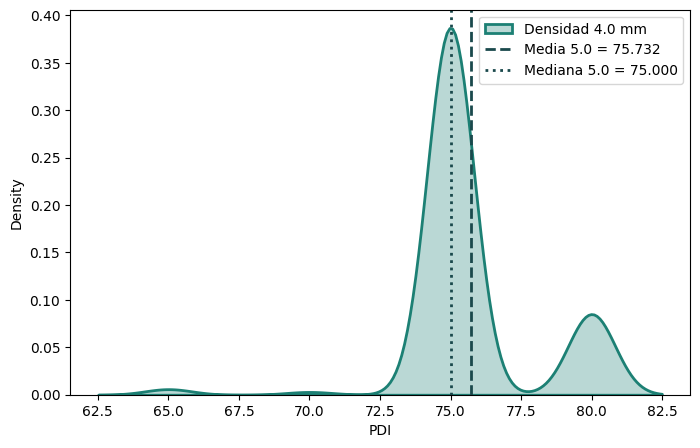

In [100]:
plt.figure(figsize=(8,5))
val = df_pel[df_pel["CÓDIGO"]==313.0]
sns.kdeplot(val["PDI"], label="Densidad 4.0 mm", color="#1c8074", linewidth=2, fill=True, alpha=0.3)
mean_4, median_4 = val["PDI"].mean(), val["PDI"].median()

plt.axvline(mean_4, color="#1a494c", linestyle="--", linewidth=2, label=f"Media 5.0 = {mean_4:.3f}")
plt.axvline(median_4, color="#1a494c", linestyle=":", linewidth=2, label=f"Mediana 5.0 = {median_4:.3f}")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # quita duplicados manteniendo todos los labels distintos
plt.legend(by_label.values(), by_label.keys(), fontsize=10)

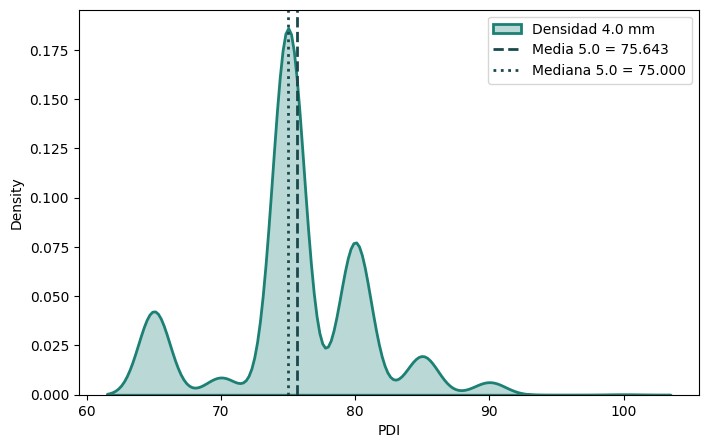

In [101]:
plt.figure(figsize=(8,5))
val = df_pel#[df_pel["CÓDIGO"]==313.0]
sns.kdeplot(val["PDI"], label="Densidad 4.0 mm", color="#1c8074", linewidth=2, fill=True, alpha=0.3)
mean_4, median_4 = val["PDI"].mean(), val["PDI"].median()

plt.axvline(mean_4, color="#1a494c", linestyle="--", linewidth=2, label=f"Media 5.0 = {mean_4:.3f}")
plt.axvline(median_4, color="#1a494c", linestyle=":", linewidth=2, label=f"Mediana 5.0 = {median_4:.3f}")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # quita duplicados manteniendo todos los labels distintos
plt.legend(by_label.values(), by_label.keys(), fontsize=10)

In [102]:
df_mico["OP"].duplicated().sum()

28

In [103]:
df_mico[df_mico.duplicated(["OP"], keep=False)].sort_values(by="OP", ascending=False)

,OP,Ecoli,Coliformes_100000,Rat_1000000,Levaduras_15000,Hongos_15000,Salmonella,Brill,Formula,Cliente,Producto,Fecha Producción,Especie,Categoria
543,1057566,0.0,0.0,2500.0,0.0,0.0,0.0,246.0,NaN,STOCK (CLIENTES),INICIO BROILER,2024-12-11 00:00:00,LEVANTE PONEDORAS,PRODUCTO TERMINADO
542,1057566,0.0,1200.0,6400.0,0.0,0.0,0.0,246.0,NaN,STOCK (CLIENTES),INICIO BROILER,2024-12-11 00:00:00,LEVANTE PONEDORAS,PRODUCTO TERMINADO
437,1055528,0.0,0.0,60000.0,32000.0,13000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
452,1055528,0.0,0.0,120000.0,39000.0,5000.0,0.0,247.0,-,STOCK (CLIENTES),FINALIZADOR BROILER,2024-11-01 00:00:00,FIN BROILER,PRODUCTO TERMINADO
453,1055528,0.0,0.0,630000.0,33000.0,3000.0,0.0,247.0,-,STOCK (CLIENTES),FINALIZADOR BROILER,2024-11-01 00:00:00,FIN BROILER,PRODUCTO TERMINADO
454,1055528,0.0,0.0,240000.0,36000.0,4000.0,0.0,247.0,-,STOCK (CLIENTES),FINALIZADOR BROILER,2024-11-01 00:00:00,FIN BROILER,PRODUCTO TERMINADO
441,1055528,0.0,0.0,18000.0,60000.0,60000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
440,1055528,0.0,0.0,19000.0,68000.0,35000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
439,1055528,0.0,0.0,53000.0,180000.0,60000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
438,1055528,0.0,0.0,67000.0,56000.0,3000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df_mico[df_mico["OP"] == 1065539]

,OP,Ecoli,Coliformes_100000,Rat_1000000,Levaduras_15000,Hongos_15000,Salmonella,Brill,Formula,Cliente,Producto,Fecha Producción,Especie,Categoria


In [105]:
df_pel[df_pel.duplicated(["OP"], keep=False)].sort_values(by="OP", ascending=False)

,HORA,OP,FECHA DE ANALISIS,FAMILIA,CÓDIGO,DESCRIPCION DEL PRODUCTO,CLIENTE,HUMEDAD,AW 0.70 MAX,PRESENCIA PLAGA,...,Densidad\n (g/l),HUMEDAD % CUMPLIDA SU VTNA. AIREACION,DADO mm,longitud mm,VOLUMEN mm^3,Analista,% HUMEDAD TEORICO,RADIO PELLET,Log Dew,PELLETIZADORA\n(CPM o ANDRITZ)
2163,14:30:00,1065539,2025-05-18,CERDOS,383.0,DESARROLLO CERDO PELLET,STOCK (CLIENTES),11.95,0.700,AUSENCIA,...,642.7,LIBERADO,5.0,10.9,214.02150,NaN,NaN,2.5,3.631137,ANDRITZ
2162,05:00:00,1065539,2025-05-18,CERDOS,383.0,DESARROLLO CERDO PELLET,STOCK (CLIENTES),11.98,0.700,AUSENCIA,...,625.3,LIBERADO,5.0,10.8,212.05800,NaN,NaN,2.5,3.631137,ANDRITZ
2212,05:30:00,1065092,2025-05-29,ENGORDE,239.0,NUTRIMAYMA FIN BROILER PELLET,STOCK (CLIENTES),12.54,0.700,AUSENCIA,...,633.1,LIBERADO,5.0,10.8,212.05800,NaN,NaN,2.5,3.631137,ANDRITZ
2136,11:00:00,1065092,2025-05-12,CERDOS,239.0,NUTRIMAYMA FIN BROILER PELLET,STOCK (CLIENTES),12.13,0.700,AUSENCIA,...,651.8,LIBERADO,5.0,7.8,153.15300,NaN,NaN,2.5,3.622873,ANDRITZ
1575,11:10:00,1059348,2025-01-15,CERDOS,385.0,FIN CERDOS RACTOP 10PPM PELLET,"DISTRIBUIDORA BONITA PAOLA, S.A.",12.09,0.650,AUSENCIA,...,622.7,LIBERADO,4.0,10.5,131.94720,NaN,NaN,2.0,3.631137,CPM
1574,08:50:00,1059348,2025-01-15,CERDOS,385.0,FIN CERDOS RACTOP 10PPM PELLET,"DISTRIBUIDORA BONITA PAOLA, S.A.",11.86,0.660,AUSENCIA,...,657.2,LIBERADO,4.0,10.8,135.71712,NaN,NaN,2.0,3.631137,CPM
1472,16:30:00,1058333,2024-12-21,ENGOREDE,847.0,FASE 2 POLLO FINALIZADOR PELLET MAQUILA VITALI,VITALI,11.22,0.640,AUSENCIA,...,630.1,RETENIDO,4.0,7.8,98.01792,NaN,NaN,2.0,3.622873,ANDRITZ
1471,16:30:00,1058333,2024-12-21,ENGOREDE,847.0,FASE 2 POLLO FINALIZADOR PELLET MAQUILA VITALI,VITALI,11.67,0.650,AUSENCIA,...,631.1,RETENIDO,4.0,7.8,98.01792,NaN,NaN,2.0,3.622873,ANDRITZ
1462,14:30:00,1057966,2024-12-19,CERDOS,398.0,INICIO CERDOS PELLET MED,"DISTRIBUIDORA BONITA PAOLA, S.A.",12.21,0.660,AUSENCIA,...,644.1,LIBERADO,4.0,10.7,134.46048,NaN,NaN,2.0,3.631137,CPM
1459,11:10:00,1057966,2024-12-19,CERDOS,398.0,INICIO CERDOS PELLET MED,"DISTRIBUIDORA BONITA PAOLA, S.A.",12.28,0.680,AUSENCIA,...,649.2,LIBERADO,4.0,10.6,133.20384,NaN,NaN,2.0,3.631137,CPM


In [106]:
df_pel["OP"] = df_pel["OP"].astype(float)
df_ganado["OP"] = df_ganado["OP"].astype(float)

In [107]:
df_mico.columns

Index(['OP', 'Ecoli', 'Coliformes_100000', 'Rat_1000000', 'Levaduras_15000',
       'Hongos_15000', 'Salmonella', 'Brill', 'Formula', 'Cliente', 'Producto',
       'Fecha Producción', 'Especie', 'Categoria'],
      dtype='object')

In [108]:
cols_mmicro = [
   'Ecoli', 'Coliformes_100000', 'Rat_1000000', 'Levaduras_15000',
       'Hongos_15000', ]

for col in cols_mmicro:
    df_mico[col] = pd.to_numeric(df_mico[col], errors="coerce")

cols_hum_aw = ['HUMEDAD', 'AW 0.70 MAX','% HUMEDAD TEORICO']

for col in cols_hum_aw:
    df_pel[col] = pd.to_numeric(df_pel[col], errors="coerce")

In [109]:
df = pd.merge(df_pel, df_mico, on='OP', how='outer', indicator=True)

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_1450/2370606372.py:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



In [110]:
df["_merge"].value_counts()

left_only     2190
right_only     287
both            59
Name: _merge, dtype: int64

In [111]:
df_ganado[df_ganado["OP"] == 1065341]

,OP,FECHA DE PRODUCCIÓN,CÓDIGO,DESCRIPCION,HUMEDAD,AW 0.70 MAX,sheet,Tamaño Particulas
876,1065341.0,2025-05-11 00:00:00,939,LACTOMAYMA 18 HARINA ASO,12.89,0.69,Ganado H,526.289091


In [112]:
df_mico[df_mico["OP"] == 1065341]

,OP,Ecoli,Coliformes_100000,Rat_1000000,Levaduras_15000,Hongos_15000,Salmonella,Brill,Formula,Cliente,Producto,Fecha Producción,Especie,Categoria
145,1065341,0.0,900.0,1000.0,300.0,100.0,0.0,939.0,NaN,STOCK (ASOCIADOS),LACTOMAYMA 18 HARINA ASO,2025-05-11 00:00:00,Ganado,Producto Terminado


In [113]:
df_pel[df_pel["OP"] == 1065341]

,HORA,OP,FECHA DE ANALISIS,FAMILIA,CÓDIGO,DESCRIPCION DEL PRODUCTO,CLIENTE,HUMEDAD,AW 0.70 MAX,PRESENCIA PLAGA,...,Densidad\n (g/l),HUMEDAD % CUMPLIDA SU VTNA. AIREACION,DADO mm,longitud mm,VOLUMEN mm^3,Analista,% HUMEDAD TEORICO,RADIO PELLET,Log Dew,PELLETIZADORA\n(CPM o ANDRITZ)


In [114]:
both = df[df["_merge"]=='both']
both["OP"].duplicated().sum()

19

In [115]:
both["OP"].nunique()

40

In [116]:
both[both.duplicated(["OP"], keep=False)].sort_values(by="OP", ascending=False)

,HORA,OP,FECHA DE ANALISIS,FAMILIA,CÓDIGO,DESCRIPCION DEL PRODUCTO,CLIENTE,HUMEDAD,AW 0.70 MAX,PRESENCIA PLAGA,...,Hongos_15000,Salmonella,Brill,Formula,Cliente,Producto,Fecha Producción,Especie,Categoria,_merge
1245,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,6000.0,0.0,247.0,-,STOCK (CLIENTES),FINALIZADOR BROILER,2024-11-01 00:00:00,FIN BROILER,PRODUCTO TERMINADO,both
1236,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,13000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,both
1244,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,6000.0,0.0,247.0,-,STOCK (CLIENTES),FINALIZADOR BROILER,2024-11-01 00:00:00,FIN BROILER,PRODUCTO TERMINADO,both
1243,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,4000.0,0.0,247.0,-,STOCK (CLIENTES),FINALIZADOR BROILER,2024-11-01 00:00:00,FIN BROILER,PRODUCTO TERMINADO,both
1242,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,3000.0,0.0,247.0,-,STOCK (CLIENTES),FINALIZADOR BROILER,2024-11-01 00:00:00,FIN BROILER,PRODUCTO TERMINADO,both
1241,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,5000.0,0.0,247.0,-,STOCK (CLIENTES),FINALIZADOR BROILER,2024-11-01 00:00:00,FIN BROILER,PRODUCTO TERMINADO,both
1240,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,60000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,both
1239,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,35000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,both
1238,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,60000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,both
1237,01:30:00,1055528.0,2024-11-04,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),12.33,0.66,AUSENCIA,...,3000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,both


In [117]:
both

,HORA,OP,FECHA DE ANALISIS,FAMILIA,CÓDIGO,DESCRIPCION DEL PRODUCTO,CLIENTE,HUMEDAD,AW 0.70 MAX,PRESENCIA PLAGA,...,Hongos_15000,Salmonella,Brill,Formula,Cliente,Producto,Fecha Producción,Especie,Categoria,_merge
38,20:15:00,1041365.0,2024-01-26,NaN,384.0,FINALIZADOR CERDOS PELLET,STOCK (CLIENTES),11.09,0.54,AUSENCIA,...,130.0,0.0,384.0,CYM,STOCK (CLIENTES),FINALIZADOR CERDOS PELLET,2024-01-26 00:00:00,CERDOS,PRODUCTO TERMINADO,both
42,14:10:00,1041471.0,2024-01-29,NaN,239.0,NUTRIMAYMA FIN BROILER PELLET,STOCK (CLIENTES),11.62,0.62,AUSENCIA,...,80.0,0.0,239.0,CYM,STOCK (CLIENTES),NUTRIMAYMA FIN BROILER PELLET,2024-01-29 00:00:00,FIN BROILER,PRODUCTO TERMINADO,both
93,05:00:00,1042024.0,2024-02-10,NaN,239.0,NUTRIMAYMA FIN BROILER PELLET,STOCK (CLIENTES),12.77,0.66,AUSENCIA,...,280.0,0.0,239.0,CYM,STOCK (CLIENTES),NUTRIMAYMA FIN BROILER PELLET,2024-02-10 00:00:00,LEVANTE BROILER,PRODUCTO TERMINADO,both
98,15:00:00,1042040.0,2024-02-12,NaN,383.0,DESARROLLO CERDO PELLET,STOCK (CLIENTES),11.44,0.60,AUSENCIA,...,150.0,0.0,383.0,CYM,STOCK (CLIENTES),DESARROLLO CERDO PELLET,2024-02-11 00:00:00,CERDOS,PRODUCTO TERMINADO,both
272,17:00:00,1045138.0,2024-04-22,CERDOS,387.0,MARRANA GESTACION PELLET ASO,STOCK (ASOCIADOS),12.66,0.65,AUSENCIA,...,140.0,0.0,387.0,CYM,STOCK (ASOCIADOS),MARRANA GESTACION PELLET ASO,2024-04-22 00:00:00,CERDOS,PRODUCTO TERMINADO,both
319,17:20:00,1046011.0,2024-05-06,CERDOS,383.0,DESARROLLO CERDO PELLET,STOCK (CLIENTES),11.99,0.62,AUSENCIA,...,40.0,0.0,383.0,CYM,STOCK (CLIENTES),DESARROLLO CERDO PELLET,2024-05-06 00:00:00,POSTURA PONEDORAS,PRODUCTO TERMINADO,both
382,11:00:00,1046575.0,2024-05-19,CERDOS,313.0,NUTRIMAYMA FINAL. CERDO PE,STOCK (CLIENTES),12.29,0.68,AUSENCIA,...,30.0,0.0,913.0,CYM,STOCK (CLIENTES),NUTRIMAYMA FINAL. CERDO PE,2024-05-18 00:00:00,CERDOS,PRODUCTO TERMINADO,both
452,21:35:00,1047484.0,2024-06-03,CERDOS,364.0,FIN CERDOS RACTOP 10PPM PE ASO,STOCK (ASOCIADOS),13.22,0.70,AUSENCIA,...,90.0,0.0,364.0,CYM,STOCK (ASOCIADOS),FIN CERDOS RACTOP 10PPM PE ASO,2024-06-03 00:00:00,CERDOS,PRODUCTO TERMINADO,both
502,23:25:00,1047927.0,2024-06-13,CERDOS,361.0,CRECIMIENTO CERDO PELLET ASO,LUIS ADALBERTO LEONARDO ILLESCAS,12.20,0.68,AUSENCIA,...,100.0,0.0,361.0,NaN,LUIS ADALBERTO LEONARDO ILLESCAS,CRECIMIENTO CERDO PELLET ASO,2024-06-13 00:00:00,CERDOS,PRODUCTO TERMINADO,both
504,02:40:00,1047928.0,2024-06-14,CERDOS,354.0,MARRANA LACTANCIA PRIMERIZA PELLET ASO,LUIS ADALBERTO LEONARDO ILLESCAS,12.98,0.70,AUSENCIA,...,80.0,0.0,354.0,NaN,LUIS ADALBERTO LEONARDO ILLESCAS,MARRANA LACTANCIA PRIMERIZA PELLET ASO,2024-06-13 00:00:00,CERDOS,PRODUCTO TERMINADO,both


In [118]:
fig = px.scatter(
    both,
    x="HUMEDAD",#AW 0.70 MAX
    y="Rat_1000000",
    hover_name="OP",
    title="Coliformes vs RAT con tamaño según Levaduras y color según Hongos"
)
fig.show()


In [201]:
fig = px.scatter(
    both,
    x="AW 0.70 MAX",#AW 0.70 MAX
    y="Rat_1000000",
    hover_name="OP",
    title="Coliformes vs RAT con tamaño según Levaduras y color según Hongos"
)
fig.show()

In [119]:
for col in cols_mmicro:
    fig = px.scatter(
        both,
        x="AW 0.70 MAX",#AW 0.70 MAX
        y=col,
        hover_name="OP",
        title=f"{col}"
    )
    fig.show()

In [120]:
for col in cols_mmicro:
    fig = px.scatter(
        both,
        x="HUMEDAD",#AW 0.70 MAX
        y=col,
        hover_name="OP",
        title=f"{col}- HUMEDAD"
    )
    fig.show()